In [ ]:
!killall python

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


ImportError: Traceback (most recent call last):
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: /home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/../../_solib_local/_U@mkl_Ulinux_S_S_Cmkl_Ulibs_Ulinux___Uexternal_Smkl_Ulinux_Slib/libiomp5.so: invalid ELF header


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
###fMRI decoding: using event signals instead of activation pattern from glm
##collect task-fMRI signals
from pathlib import Path
pathroot=Path('/home/yuzhang/scratch/HCP/aws_s3_HCP1200/FMRI/')
modality = 'WM' #'MOTOR'

pathdata = pathroot
pathout = '/home/yuzhang/scratch/HCP/temp_res_new/'
print(pathdata)

import os
import glob
subjects = []
fmri_files = []
confound_files = []
for fmri_file in sorted(pathdata.glob('tfMRI_'+modality+'_??'+'/*_tfMRI_'+modality+'_??.nii.gz')):
    subjects.append(Path(os.path.dirname(fmri_file)).parts[-3])
    fmri_files.append(str(fmri_file))

for confound in sorted(pathdata.glob('tfMRI_'+modality+'_??'+'/*_Movement_Regressors.txt')):
    confound_files.append(str(confound))

EVS_files = [];
for ev in sorted(pathdata.glob('tfMRI_'+modality+'_??'+'/*_combined_events_spm_'+modality+'.csv')):
    EVS_files.append(str(ev))
    
print('%d subjects included in the dataset' % len(fmri_files))
#print(fmri_files)
#print(EVS_files)
print(len(fmri_files),len(confound_files),len(EVS_files))

from pathlib import Path
import os
import glob
modality = 'WM' #'MOTOR'
fmri_file = '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/668361/FMRI/tfMRI_WM_LR/tfMRI_WM_LR.nii.gz'
pathsub = Path(os.path.dirname(fmri_file))
print(pathsub)
evfiles_combined = str(pathsub)+"/combined_events_spm_"+modality+".csv"
if not os.path.isfile(evfiles_combined):
    evs = []
    ev_names = []
    if not os.path.isdir(str(pathsub) + '/EVs/'):
        print('Event files not exist!\n Check data folder:%s' % str(pathsub))

    for ev in sorted(pathsub.glob('EVs/*.txt')):
        ev_name = str(os.path.basename(str(ev))).split('.',1)[0]
        if ev_name in task_contrasts.keys() and os.stat(str(ev)).st_size:
            ev_names.append(np.repeat(ev_name,len(pd.read_csv(ev,header = None).index)))
            evs.append(str(ev))

    combined_csv = pd.concat( [ pd.read_csv(f,sep="\t",encoding="utf8",header = None,names=['onset','duration','rep']) for f in evs ] )
    combined_csv['task'] = list(itertools.chain(*ev_names))  #np.array(ev_names).flatten()
    combined_csv_sort = combined_csv.sort_values('onset')
    combined_csv_sort.to_csv( evfiles_combined, float_format='%.3f', sep='\t', encoding='utf-8', index=False,header=False)


In [3]:
###combining multiple sessions together
import os
import numpy as np
import pandas as pd
import nibabel as nib

tc_matrix = nib.load(fmri_files[0])
Subject_Num = len(fmri_files)
Trial_Num = tc_matrix.shape[-1]
#print("Data samples including %d subjects with %d trials and %d nodes for each" % (Subject_Num, Trial_Num,Node_Num))

modality = 'WM' #'MOTOR'
###dict for different types of movement
motor_task_con = {"rf": "foot",
                  "lf": "foot",
                  "rh": "hand",
                  "lh": "hand",
                  "t": "tongue"}
wm_task_con = {"2bk_body": "body2b_wm",
               "2bk_faces": "face2b_wm",
               "2bk_places": "place2b_wm",
               "2bk_tools": "tool2b_wm",
               "0bk_body": "body0b_wm",
               "0bk_faces": "face0b_wm",
               "0bk_places": "place0b_wm",
               "0bk_tools": "tool0b_wm"}
task_contrasts = wm_task_con
###to extract stimuli types
#target_name = np.unique(pd.Series(list(task_contrasts.values())).str.split('_',expand = True)[0])
target_name = np.unique(list(task_contrasts.values()))
print(target_name)
TR = 0.72

EVS_files = []
subj = 0
###adjust the code after changing to the new folder
for ev, sub_count in zip(sorted(pathdata.glob('tfMRI_' + modality + '_??/*combined_events_spm_' + modality + '.csv')),range(Subject_Num)):
    ###remove fmri files if the event design is missing
    while os.path.basename(fmri_files[subj]).split('_')[0] < os.path.basename(str(ev)).split('_')[0]:
        print("Event files and fmri data are miss-matching for subject: ")
        print(os.path.basename(str(ev)).split('_')[0], ':', os.path.basename(fmri_files[subj]).split('_')[0])
        print("Due to missing event files for subject : %s" % os.path.basename(fmri_files[subj]))
        fmri_files[subj] = []
        confound_files[subj] = []
        subj += 1
        if subj > Subject_Num:
            break
    if os.path.basename(fmri_files[subj]).split('_')[0] == os.path.basename(str(ev)).split('_')[0]:
        EVS_files.append(str(ev))
        subj += 1

fmri_files = list(filter(None, fmri_files))
confound_files = list(filter(None, confound_files))
if len(EVS_files) != len(fmri_files):
    print('Miss-matching number of subjects between event:{} and fmri:{} files'.format(len(EVS_files), len(fmri_files)))
        

###loading all event designs
events_all_subjects_file = pathout+modality+"_event_labels_1200R_LR_RL_new.txt"
print(events_all_subjects_file)
if os.path.isfile(events_all_subjects_file):
    trial_infos = pd.read_csv(EVS_files[0],sep="\t",encoding="utf8",header = None,names=['onset','duration','rep','task'])
    Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)

    print('Collecting trial info from file:', events_all_subjects_file)
    subjects_trial_labels = pd.read_csv(events_all_subjects_file,sep="\t",encoding="utf8")
    ###print(subjects_trial_labels.keys())

    subjects_trial_label_matrix = subjects_trial_labels.loc[:, 'trial1':'trial' + str(Trial_Num)]
    ##subjects_trial_label_matrix = subjects_trial_labels.values.tolist()
    trialID = subjects_trial_labels['trialID']
    sub_name = subjects_trial_labels['subject'].tolist()
    coding_direct = subjects_trial_labels['coding']
    print(np.array(subjects_trial_label_matrix).shape,len(sub_name),len(np.unique(sub_name)),len(coding_direct))
else:
    print('Loading trial info for each task-fmri file and save to csv file:', events_all_subjects_file)
    subjects_trial_label_matrix = []
    sub_name = []
    coding_direct = []
    for subj in np.arange(Subject_Num):
        pathsub = Path(os.path.dirname(EVS_files[subj]))
        #sub_name.append(pathsub.parts[-3])
        ###adjust the code after changing to the new folder
        sub_name.append(str(os.path.basename(EVS_files[subj]).split('_')[0]))
        coding_direct.append(pathsub.parts[-1].split('_')[-1])

        ##trial info in volume
        trial_infos = pd.read_csv(EVS_files[subj],sep="\t",encoding="utf8",header = None,names=['onset','duration','rep','task'])
        Onsets = np.ceil((trial_infos.onset/TR)).astype(int) #(trial_infos.onset/TR).astype(int)
        Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)
        Movetypes = trial_infos.task

        labels = ["rest"]*Trial_Num;
        trialID = [0] * Trial_Num;
        tid = 1
        for start,dur,move in zip(Onsets,Duras,Movetypes):
            for ti in range(start-1,start+dur):
                labels[ti]= task_contrasts[move]
                trialID[ti] = tid
            tid += 1
        subjects_trial_label_matrix.append(labels)

    ##subjects_trial_label_matrix = np.array(subjects_trial_label_matrix)
    print(np.array(subjects_trial_label_matrix).shape)
    #print(np.array(subjects_trial_label_matrix[0]))
    subjects_trial_labels = pd.DataFrame(data=np.array(subjects_trial_label_matrix),columns=['trial'+str(i+1) for i in range(Trial_Num)])
    subjects_trial_labels['trialID'] = tid
    subjects_trial_labels['subject'] = sub_name
    subjects_trial_labels['coding'] = coding_direct
    subjects_trial_labels.keys()
    subjects_trial_label_matrix = pd.DataFrame(data=np.array(subjects_trial_label_matrix),columns=['trial'+str(i+1) for i in range(Trial_Num)])

    ##save the labels
    subjects_trial_labels.to_csv(events_all_subjects_file,sep='\t', encoding='utf-8',index=False)

['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']
/home/yuzhang/scratch/HCP/temp_res_new/WM_event_labels_1200R_LR_RL_new.txt
(2148, 405) 2148 1079 2148


In [7]:
from nilearn import signal
from nilearn import image
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from keras.utils import np_utils
from keras.utils import to_categorical

from tensorpack import dataflow
#from tensorpack.utils.gpu import get_num_gpu
from keras.utils.training_utils import multi_gpu_model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout,AveragePooling2D
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, AveragePooling3D
from keras.models import Model
from keras import regularizers
from keras import backend as K

class gen_fmri_file(dataflow.DataFlow):
    """ Iterate through fmri filenames, confound filenames and labels
    """
    def __init__(self, fmri_files,confound_files, label_matrix,data_type='train',train_percent=0.8):
        assert (len(fmri_files) == len(confound_files))
        # self.data=zip(fmri_files,confound_files)
        self.fmri_files = fmri_files
        self.confound_files = confound_files
        self.label_matrix = label_matrix
        
        self.data_type=data_type
        self.train_percent=train_percent

    def size(self):
        split_num=int(len(self.fmri_files)*0.8)
        if self.data_type=='train':
            return split_num
        else:
            return len(self.fmri_files)-split_num

    def get_data(self):
        split_num=int(len(self.fmri_files)*0.8)
        if self.data_type=='train':
            while True:
                rand_pos=np.random.choice(split_num,1)[0]
                yield self.fmri_files[rand_pos],self.confound_files[rand_pos],self.label_matrix.iloc[rand_pos]
        else:
            for pos_ in range(split_num,len(self.fmri_files)):
                yield self.fmri_files[pos_],self.confound_files[pos_],self.label_matrix.iloc[pos_]


class split_samples(dataflow.DataFlow):
    """ Iterate through fmri filenames, confound filenames and labels
    """
    def __init__(self, ds):
        self.ds=ds

    def size(self):
        #return 91*284
        return 1e20

    def data_info(self):
        for data in self.ds.get_data():
            print('fmri/label data shape:',data[0].shape,data[1].shape)
            return data[0].shape

    def get_data(self):
        for data in self.ds.get_data():
            for i in range(data[1].shape[0]):
                ####yield data[0][i],data[1][i]
                yield data[0][i].astype('float32',casting='same_kind'),data[1][i]
          
        
def map_load_fmri_image_block(dp,target_name,block_dura=1):
    ###extract time-series within each block in terms of trial numbers
    fmri_file=dp[0]
    confound_file=dp[1]
    label_trials=dp[2]
    '''
    ###remove confound effects
    confound = np.loadtxt(confound_file)
    ##using orthogonal matrix instead of original matrix
    normed_matrix = preprocessing.normalize(confound, axis=0, norm='l2')
    confound, R = np.linalg.qr(normed_matrix)
    mask_img = masking.compute_epi_mask(fmri_file)
    fmri_data_clean = image.clean_img(fmri_file, detrend=False, standardize=True, confounds=confound, t_r=TR, ensure_finite=True, mask_img=mask_img)
    '''
    fmri_data_clean = fmri_file
    ##pre-select task types
    trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
    fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0]).get_data().astype('float32',casting='same_kind')
    img_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]
    fmri_data_cnn = fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:-1]),fmri_data_cnn.shape[-1])
    fmri_data_cnn = preprocessing.scale(fmri_data_cnn, axis=1).astype('float32',casting='same_kind')
    fmri_data_cnn[np.isnan(fmri_data_cnn)] = 0
    fmri_data_cnn[np.isinf(fmri_data_cnn)] = 0
    fmri_data_cnn = fmri_data_cnn.reshape((img_rows, img_cols, img_deps,fmri_data_cnn.shape[-1]))

    ###use each slice along z-axis as one sample
    label_data_trial = np.array(label_trials.loc[trial_mask])
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    label_data_int = le.transform(label_data_trial)

    ##cut the trials
    chunks = int(np.floor(len(label_data_trial) / block_dura))
    label_data_trial_block = np.array(np.split(label_data_trial, np.where(np.diff(label_data_int))[0] + 1))
    fmri_data_cnn_block = np.array_split(fmri_data_cnn, np.where(np.diff(label_data_int))[0] + 1, axis=3)
    #ulabel = [np.unique(x) for x in label_data_trial_block]
    #print("After cutting: unique values for each block of trials %s with %d blocks" % (np.array(ulabel), len(ulabel)))
    ##print(np.unique(label_data_int),len(label_data_int))
    
    if label_data_trial_block.shape[0] != chunks:
        print("Wrong cutting of event data...")
        print("Should have %d block-trials but only found %d cuts" % (chunks, label_data_trial_block.shape[0]))
        label_data_trial_block = np.array(np.split(label_data_trial, chunks))
        fmri_data_cnn_block = np.array_split(fmri_data_cnn, chunks, axis=3)
        ulabel = [np.unique(x) for x in label_data_trial_block]
        #print("Adjust the cutting: unique values for each block of trials %s with %d blocks" % (np.array(ulabel), len(ulabel)))

    label_data = np.array([label_data_trial_block[i][:block_dura] for i in range(chunks)])
    label_data_cnn_test = le.transform(np.repeat(label_data[:, 0], img_deps, axis=0)).flatten()
    ##fmri_data_cnn_block = np.array_split(fmri_data_cnn, np.where(np.diff(label_data_int))[0] + 1, axis=3)
    fmri_data_cnn_test = np.array([fmri_data_cnn_block[i][:, :, :, :block_dura] for i in range(chunks)])
    fmri_data_cnn = None
    fmri_data_cnn_block = None
    ###reshape data to fit the model
    fmri_data_cnn_test = np.transpose(fmri_data_cnn_test, (3, 0, 1, 2, 4))
    fmri_data_cnn_test = fmri_data_cnn_test.reshape(np.prod(fmri_data_cnn_test.shape[:2]), img_rows, img_cols,block_dura)
    ##print(fmri_data_clean, fmri_data_cnn_test.shape, label_data_cnn_test.shape)

    return fmri_data_cnn_test, label_data_cnn_test

def map_load_fmri_image_3d_block(dp, target_name,block_dura=1):
    fmri_file = dp[0]
    confound_file = dp[1]
    label_trials = dp[2]
    fmri_data_clean = fmri_file

    ##pre-select task types
    trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
    #fmri_data_cnn = image.index_img(fmri_data_clean_resample, np.where(trial_mask)[0]).get_data()
    fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0]).get_data().astype('float32',casting='same_kind')
    img_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]
    #min_max_scaler = preprocessing.MinMaxScaler()
    #fmri_data_cnn = min_max_scaler.fit_transform(fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:-1]),fmri_data_cnn.shape[-1]))
    fmri_data_cnn = fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:-1]),fmri_data_cnn.shape[-1])
    fmri_data_cnn = preprocessing.scale(fmri_data_cnn, axis=1).astype('float32',casting='same_kind')
    fmri_data_cnn[np.isnan(fmri_data_cnn)] = 0
    fmri_data_cnn[np.isinf(fmri_data_cnn)] = 0
    fmri_data_cnn = fmri_data_cnn.reshape((img_rows, img_cols, img_deps,fmri_data_cnn.shape[-1]))

    ###use each slice along z-axis as one sample
    label_data_trial = np.array(label_trials.loc[trial_mask])
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    label_data_int = le.transform(label_data_trial)

    ##cut the trials
    chunks = int(np.floor(len(label_data_trial) / block_dura))
    label_data_trial_block = np.array(np.split(label_data_trial, np.where(np.diff(label_data_int))[0] + 1))
    fmri_data_cnn_block = np.array_split(fmri_data_cnn, np.where(np.diff(label_data_int))[0] + 1, axis=3)
    #ulabel = [np.unique(x) for x in label_data_trial_block]
    #print("After cutting: unique values for each block of trials %s with %d blocks" % (np.array(ulabel), len(ulabel)))
    if label_data_trial_block.shape[0] != chunks:
        print("Wrong cutting of event data...")
        print("Should have %d block-trials but only found %d cuts" % (chunks, label_data_trial_block.shape[0]))
        label_data_trial_block = np.array(np.split(label_data_trial, chunks))
        fmri_data_cnn_block = np.array_split(fmri_data_cnn, chunks, axis=3)
        ulabel = [np.unique(x) for x in label_data_trial_block]
        print("Adjust the cutting: unique values for each block of trials %s with %d blocks" % (np.array(ulabel), len(ulabel)))

    label_data = np.array([label_data_trial_block[i][:block_dura] for i in range(chunks)])
    label_data_cnn_test = le.transform(label_data[:, 0]).flatten()
    ##fmri_data_cnn_block = np.array_split(fmri_data_cnn, np.where(np.diff(label_data_int))[0] + 1, axis=3)
    fmri_data_cnn = None
    fmri_data_cnn_test = np.array([fmri_data_cnn_block[i][:, :, :, :block_dura] for i in range(chunks)])
    fmri_data_cnn_block = None
    ##print(fmri_file, fmri_data_cnn_test.shape, label_data_cnn_test.shape)

    return fmri_data_cnn_test, label_data_cnn_test

def data_pipe_3dcnn_block(fmri_files, confound_files, label_matrix, target_name=None, flag_cnn='3d', block_dura=1,
                    batch_size=32,data_type='train',train_percent=0.8, nr_thread=2, buffer_size=4):
    assert data_type in ['train', 'val', 'test']
    assert flag_cnn in ['3d', '2d']
    assert fmri_files is not None
    isTrain = data_type == 'train'

    print('\n\nGenerating dataflow for %s datasets \n' % data_type)

    buffer_size = int(min(len(fmri_files), buffer_size))
    nr_thread = int(min(len(fmri_files), nr_thread))

    ds0 = gen_fmri_file(fmri_files, confound_files, label_matrix, data_type=data_type, train_percent=train_percent)
    print('dataflowSize is ' + str(ds0.size()))
    print('Loading data using %d threads with %d buffer_size ... \n' % (nr_thread, buffer_size))

    if target_name is None:
        target_name = np.unique(label_matrix)
    ##Subject_Num, Trial_Num = np.array(label_matrix).shape

    ####running the model
    start_time = time.clock()
    if flag_cnn == '2d':
        ds1 = dataflow.MultiThreadMapData(
            ds0, nr_thread=nr_thread,
            map_func=lambda dp: map_load_fmri_image_block(dp, target_name,block_dura=block_dura),
            buffer_size=buffer_size,
            strict=True)
    elif flag_cnn == '3d':
        ds1 = dataflow.MultiThreadMapData(
            ds0, nr_thread=nr_thread,
            map_func=lambda dp: map_load_fmri_image_3d_block(dp, target_name,block_dura=block_dura),
            buffer_size=buffer_size,
            strict=True)

    ds1 = dataflow.PrefetchData(ds1, buffer_size, 1)

    ds1 = split_samples(ds1)
    print('prefetch dataflowSize is ' + str(ds1.size()))
    ds_data_shape= ds1.data_info()
    Trial_Num = ds_data_shape[0]
    Block_dura = ds_data_shape[-1]
    print('%d #Trials/Samples per subject with %d channels in tc' % (Trial_Num,Block_dura))

    if isTrain:
        #ds1 = dataflow.LocallyShuffleData(ds1, buffer_size=ds1.size() * buffer_size)
        ds1 = dataflow.LocallyShuffleData(ds1, buffer_size=Trial_Num * buffer_size)

    ds1 = dataflow.BatchData(ds1, batch_size=batch_size, remainder=True)
    print('Time Usage of loading data in seconds: {} \n'.format(time.clock() - start_time))

    ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
    ds1._reset_once()
    ##ds1.reset_state()
    '''
    for df in ds1.get_data():
        if flag_cnn == '2d':
            yield (df[0].astype('float32'),to_categorical(df[1].astype('int32'), len(target_name)))
        elif flag_cnn == '3d':
            yield (df[0].astype('float32'),to_categorical(df[1].astype('int32'), len(target_name)))
    '''
    return ds1

In [6]:
import time
block_dura=39
Trial_dura = 39
print(target_name)
label_matrix=subjects_trial_label_matrix

test_sub_num = 100
tst = data_pipe_3dcnn_block(fmri_files[:test_sub_num], confound_files[:test_sub_num], label_matrix.iloc[:test_sub_num],
                      target_name=target_name, flag_cnn='2d', train_percent=0.8, block_dura=block_dura,
                      batch_size=16, data_type='train', nr_thread=4, buffer_size=8)

out = next(tst)
print(out[0].shape)
print(out[1].shape)

['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']


Generating dataflow for train datasets 

dataflowSize is 80
Loading data using 4 threads with 8 buffer_size ... 

prefetch dataflowSize is 1e+20


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


fmri/label data shape: (728, 91, 109, 39) (728,)
728 #Trials/Samples per subject with 39 channels in tc
Time Usage of loading data in seconds: 2.8119320000000023 



/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/msgpack_numpy.py:133: PendingDeprecationWarning: encoding is deprecated.
  use_bin_type=use_bin_type)


(16, 91, 109, 39)
(16, 8)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/msgpack_numpy.py:77: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


In [8]:
nr_thread = 2
buffer_size = 4
batch_size = 8
block_dura = 39
Flag_CNN_Model = '2d'
test_sub_num = 100
val_size = 0.2
rs = np.random.RandomState(1234)

train_sid, val_sid = train_test_split(range(test_sub_num), test_size=val_size, random_state=rs, shuffle=True)
fmri_data_train = np.array([fmri_files[i] for i in train_sid])
confounds_train = np.array([confound_files[i] for i in train_sid])
label_train = pd.DataFrame(np.array([label_matrix.iloc[i] for i in train_sid]))

fmri_data_val = np.array([fmri_files[i] for i in val_sid])
confounds_val = np.array([confound_files[i] for i in val_sid])
label_val = pd.DataFrame(np.array([label_matrix.iloc[i] for i in val_sid]))

#########################################
train_gen = data_pipe_3dcnn_block(fmri_data_train, confounds_train,label_train,
                                  target_name=target_name, flag_cnn=Flag_CNN_Model, train_percent=0.8, block_dura=block_dura,
                                  batch_size=batch_size, data_type='train', nr_thread=nr_thread, buffer_size=buffer_size)
val_set = data_pipe_3dcnn_block(fmri_data_val, confounds_val,label_val,
                                target_name=target_name, flag_cnn=Flag_CNN_Model, train_percent=0.8, block_dura=block_dura,
                                batch_size=batch_size, data_type='train', nr_thread=nr_thread, buffer_size=buffer_size)

#########################################
def one_hot(label):
    return np.eye(10)[label]

train_gen = dataflow.MapDataComponent(train_gen, one_hot, 1)
val_set = dataflow.MapDataComponent(val_set, one_hot, 1)





Generating dataflow for train datasets 

dataflowSize is 64
Loading data using 2 threads with 4 buffer_size ... 

prefetch dataflowSize is 1e+20


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


fmri/label data shape: (728, 91, 109, 39) (728,)
728 #Trials/Samples per subject with 39 channels in tc
Time Usage of loading data in seconds: 3.019758999999997 



Generating dataflow for train datasets 

dataflowSize is 16
Loading data using 2 threads with 4 buffer_size ... 

prefetch dataflowSize is 1e+20


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


fmri/label data shape: (728, 91, 109, 39) (728,)
728 #Trials/Samples per subject with 39 channels in tc
Time Usage of loading data in seconds: 2.72316 



/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/msgpack_numpy.py:133: PendingDeprecationWarning: encoding is deprecated.
  use_bin_type=use_bin_type)
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/msgpack_numpy.py:133: PendingDeprecationWarning: encoding is deprecated.
  use_bin_type=use_bin_type)


In [14]:
def build_cnn_model_test(input_shape, Nlabels, filters=16, convsize=3, convsize2=5, poolsize=2, hidden_size=256, conv_layers=4):
    #     import keras.backend as K
    #     if K.image_data_format() == 'channels_first':
    #         img_shape = (1,img_rows,img_cols)
    #     elif K.image_data_format() == 'channels_last':
    #         img_shape = (img_rows,img_cols,1)
    from keras import regularizers
    input0 = Input(shape=input_shape)
    drop1 = input0
    ####quickly reducing image dimension first
    for li in range(1):
        conv1 = Conv2D(filters, (convsize, convsize), strides=2, padding='same',activation='relu',
                    kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg))(drop1)
        conv1 = BatchNormalization()(conv1)
        #pool1 = MaxPooling2D((poolsize, poolsize))(conv1)
        #drop1 = Dropout(0.25)(pool1)
        drop1 = Dropout(0.25)(conv1)
        filters *= 2
    for li in range(conv_layers-1):
        conv1 = Conv2D(filters, convsize, padding='same',activation='relu',
                    kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg))(drop1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(filters, convsize2, padding='same',activation='relu',
                    kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg))(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(filters, (convsize, convsize), strides=2, padding='same',activation='relu',
                    kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg))(conv1)
        conv1 = BatchNormalization()(conv1)
        #pool1 = MaxPooling2D((poolsize, poolsize))(conv1)
        #drop1 = Dropout(0.25)(pool1)
        drop1 = Dropout(0.25)(conv1)
        if (li+1) % 2 == 0:
            filters *= 2

    drop2 = drop1
    avg1 = AveragePooling2D(pool_size=(5, 5))(drop2)
    flat = Flatten()(avg1)
    hidden = Dense(hidden_size, kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg), activation='relu')(flat)
    drop3 = Dropout(0.4)(hidden)
    #hidden = Dense(int(hidden_size/4),kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l2_reg), activation='relu')(drop3)
    #drop4 = Dropout(0.5)(hidden)

    out = Dense(Nlabels, activation='softmax')(drop3)

    model = Model(inputs=input0, outputs=out)
    model.summary()
    '''
    adam = Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    '''
    return model

################################################
learning_rate_decay = 0.9
l2_reg = 0.0001

nb_class = len(target_name)
img_shape = []
if Flag_CNN_Model == '2d':
    tc_matrix = nib.load(fmri_files[0])
    img_rows, img_cols, img_deps = tc_matrix.shape[:-1]
    if K.image_data_format() == 'channels_first':
        img_shape = (block_dura, img_rows, img_cols)
    elif K.image_data_format() == 'channels_last':
        img_shape = (img_rows, img_cols, block_dura)
elif Flag_CNN_Model == '3d':
    ##fmri_data_resample = image.resample_img(fmri_files[0], target_affine=np.diag((img_resize, img_resize, img_resize)))
    fmri_data_resample = nib.load(fmri_files[0])
    img_rows, img_cols, img_deps = fmri_data_resample.get_data().shape[:-1]
    if K.image_data_format() == 'channels_first':
        img_shape = (block_dura, img_rows, img_cols, img_deps)
    elif K.image_data_format() == 'channels_last':
        img_shape = (img_rows, img_cols, img_deps, block_dura)
print("fmri data in shape: ",img_shape)

USE_GPU_CPU = 1
num_GPU = 1  ##get_num_gpu()
print('\nAvaliable GPUs for usage: %d \n' % num_GPU)
model_test = build_cnn_model_test(img_shape, nb_class)
if USE_GPU_CPU and num_GPU > 1:
    model_test_GPU = multi_gpu_model(model_test, gpus=num_GPU)
else:
    model_test_GPU = model_test

from tensorpack.contrib.keras import KerasModel
model_test_GPU_new = KerasModel(model_test_GPU,
                                inputs_desc=[InputDesc(tf.float32, (None,) + img_shape, 'images')],
                                targets_desc=[InputDesc(tf.uint8, (None, len(target_name)), 'labels')],
                                input=train_gen, trainer=SyncMultiGPUTrainerReplicated(num_GPU))
model_test_GPU_new.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy', metrics='categorical_accuracy')
callbacks = [ModelSaver(), GPUUtilizationTracker(),
             DataParallelInferenceRunner(val_set, ScalarStats(['categorical_accuracy']), num_GPU)]
model_test_GPU_new.fit(steps_per_epoch=100, max_epoch=100, callbacks=callbacks)

fmri data in shape:  (91, 109, 39)

Avaliable GPUs for usage: 1 



/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 91, 109, 39)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 46, 55, 16)        5632      
_________________________________________________________________
batch_normalization_31 (Batc (None, 46, 55, 16)        64        
_________________________________________________________________
dropout_16 (Dropout)         (None, 46, 55, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 46, 55, 32)        4640      
_________________________________________________________________
batch_normalization_32 (Batc (None, 46, 55, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 46, 55, 32)        25632     
__________

ModuleNotFoundError: No module named 'tensorpack.contrib'

In [9]:
'''
fmri_data_clean = fmri_files[0]
##pre-select task types
trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0]).get_data().astype('float32',casting='same_kind')
img_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]
#min_max_scaler = preprocessing.MinMaxScaler()
#fmri_data_cnn = min_max_scaler.fit_transform(fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:-1]),fmri_data_cnn.shape[-1]))
fmri_data_cnn = fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:-1]),fmri_data_cnn.shape[-1])
fmri_data_cnn = preprocessing.scale(fmri_data_cnn, axis=1).astype('float32',casting='same_kind')
fmri_data_cnn[np.isnan(fmri_data_cnn)] = 0
fmri_data_cnn[np.isinf(fmri_data_cnn)] = 0
fmri_data_cnn = fmri_data_cnn.reshape((img_rows, img_cols, img_deps,fmri_data_cnn.shape[-1]))
'''

###use each slice along z-axis as one sample
label_data_trial = np.array(label_trials.loc[trial_mask])
le = preprocessing.LabelEncoder()
le.fit(target_name)
label_data_int = le.transform(label_data_trial)

##cut the trials into blocks
chunks = int(np.floor(len(label_data_trial)/block_dura))
label_data_trial_block = np.array(np.split(label_data_trial, np.where(np.diff(label_data_int))[0]+1))
if label_data_trial_block.shape[0] != chunks:
    print("Wrong cutting of event data...")
    print("Should have %d block-trials but only found %d cuts" % (chunks,label_data_trial_block.shape[0]))

label_data = np.array([label_data_trial_block[i][:block_dura] for i in range(chunks)]) 
print(label_data.shape)
label_data_cnn_test = le.transform(np.repeat(label_data[:,0], img_deps, axis=0)).flatten()
print(label_data_cnn_test.shape)

fmri_data_cnn_block = np.array_split(fmri_data_cnn,np.where(np.diff(label_data_int))[0]+1,axis=3)
fmri_data_cnn_test = np.array([fmri_data_cnn_block[i][:,:,:,:block_dura] for i in range(chunks)])
print(fmri_data_cnn_test.shape)
###reshape data to fit the model
fmri_data_cnn_test = np.transpose(fmri_data_cnn_test,(3,0,1,2,4))
print(fmri_data_cnn_test.shape)
fmri_data_cnn_test = fmri_data_cnn_test.reshape(np.prod(fmri_data_cnn_test.shape[:2]),img_rows, img_cols, block_dura)
print(fmri_data_clean, fmri_data_cnn_test.shape, label_data_cnn_test.shape)


(8, 39)
(728,)
(8, 91, 109, 91, 39)
(91, 8, 91, 109, 39)
/home/yuzhang/scratch/HCP/aws_s3_HCP1200/FMRI/tfMRI_WM_LR/100206_tfMRI_WM_LR.nii.gz (728, 91, 109, 39) (728,)


"\n###use each slice along z-axis as one sample\nlabel_data_trial = np.array(label_trials.loc[trial_mask])\nimg_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]\n\n##cut the trials into blocks\nchunks = int(np.floor(len(label_data_trial)/block_dura))\nfmri_data_cnn = np.array(np.array_split(fmri_data_cnn,chunks,axis=3))\nif block_dura != fmri_data_cnn.shape[-1]:\n    print('adjust the duration of each block from %d to %d' % (block_dura,fmri_data_cnn.shape[-1]))\n    block_dura = fmri_data_cnn.shape[-1]\n\nlabel_data_trial_block = np.array_split(label_data_trial,chunks)\nlabel_data_trial_block = list(zip(*label_data_trial_block))[0]\nle = preprocessing.LabelEncoder()\nle.fit(target_name)\nlabel_data_cnn_block = le.transform(label_data_trial_block) ##np_utils.to_categorical(): convert label vector to matrix\n\n###reshape data to fit the model\nfmri_data_cnn = np.transpose(fmri_data_cnn,(3,0,1,2,4))\nfmri_data_cnn_test = fmri_data_cnn.reshape(np.prod(fmri_data_cnn.shape[:2]),img_rows, 

TypeError: object of type 'NoneType' has no len()

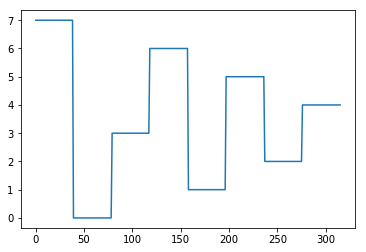

In [27]:
le = preprocessing.LabelEncoder()
le.fit(target_name)
label_data_int = le.transform(label_data_trial)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(label_data_int)

import pandas as pd

block_dura=13
Trial_dura = 39

##cut the trials into blocks
chunks = int(np.floor(len(label_data_trial)/Trial_dura))
label_data_trial_block = np.array(np.split(label_data_trial, np.where(np.diff(label_data_int))[0]+1))
if label_data_trial_block.shape[0] != chunks:
    print("Wrong cutting of event data...")
    print("Should have %d block-trials but only found %d cuts" % (chunks,label_data_trial_block.shape[0]))

label_data_cnn = np.array([label_data_trial_block[i][:Trial_dura] for i in range(chunks)]) 

fmri_data_cnn_block = np.array_split(fmri_data_cnn,np.where(np.diff(label_data_int))[0]+1,axis=3)
fmri_data_cnn = np.array([fmri_data_cnn_block[i][:,:,:,:Trial_dura] for i in range(chunks)])
fmri_data_cnn_block = None
print('first cut:',fmri_data_cnn.shape,label_data_cnn.shape)

chunks = int(np.ceil(Trial_dura / block_dura))
##cut the trials into blocks
if not (trial_dura % block_dura):
    fmri_data_block = np.array(np.vstack(np.array_split(fmri_data_cnn, chunks, axis=2)[:-1]))
    label_data_block = np.array(np.vstack(np.array_split(label_data_cnn, chunks, axis=2)[:-1]))[:,:,0]
    print('second cut:',fmri_data_block.shape,label_data_block.shape)



In [ ]:
for fi in range(10):
    fmri_data_clean = fmri_files[fi]
    ##pre-select task types
    trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
    fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0])
    fmri_data_cnn_crop = image.crop_img(fmri_data_cnn,rtol=1e-2).get_data()
    print(fmri_data_cnn_crop.shape,fmri_data_cnn.get_data().shape)

    img_rows, img_cols, img_deps = fmri_data_cnn_crop.shape[:-1]
    fmri_data_cnn_2d = fmri_data_cnn_crop.reshape(np.prod(fmri_data_cnn_crop.shape[:-1]),fmri_data_cnn_crop.shape[-1])
    fmri_data_cnn_2d = preprocessing.scale(fmri_data_cnn_2d, axis=1)
    fmri_data_cnn_2d[np.isnan(fmri_data_cnn_2d)] = 0
    fmri_data_cnn_input = fmri_data_cnn_2d.reshape((img_rows, img_cols, img_deps,fmri_data_cnn_crop.shape[-1]))

plotting.plot_stat_map(image.index_img(fmri_data_clean,10))
plotting.plot_stat_map(image.index_img(fmri_data_cnn,10))
plotting.plot_stat_map(image.index_img(image.crop_img(fmri_data_cnn,rtol=1e-2),10))

/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


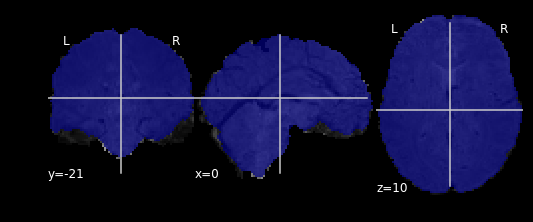

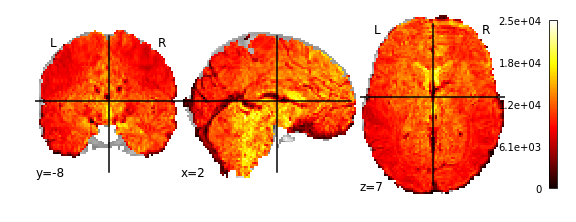

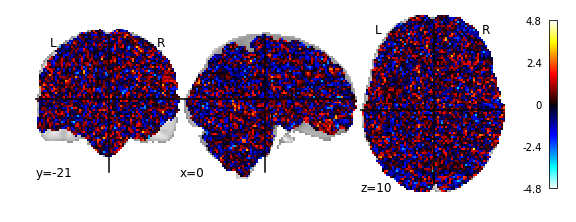

In [7]:
confound = np.loadtxt(confound_files[0])
normed_matrix = normalize(confound, axis=0, norm='l2')
confound, R = np.linalg.qr(normed_matrix)

#confound = np.ones((TrialNum,12), dtype=int)
brainmask = masking.compute_epi_mask(fmri_files[0])
plotting.plot_roi(brainmask, image.mean_img(fmri_files[0]))
fmri_data_clean = image.clean_img(fmri_files[0], detrend=False, standardize=True, confounds=confound,mask_img=brainmask)

plotting.plot_stat_map(image.index_img(fmri_files[0],10))
plotting.plot_stat_map(image.index_img(fmri_data_clean,10))


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


(215176, 284)


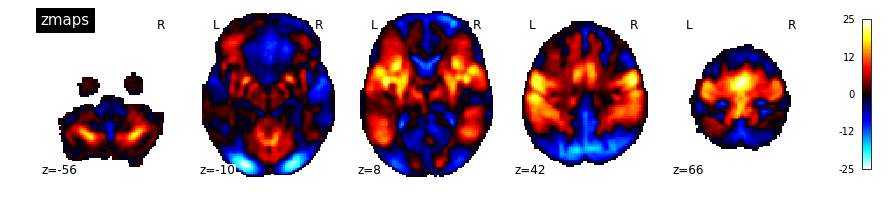

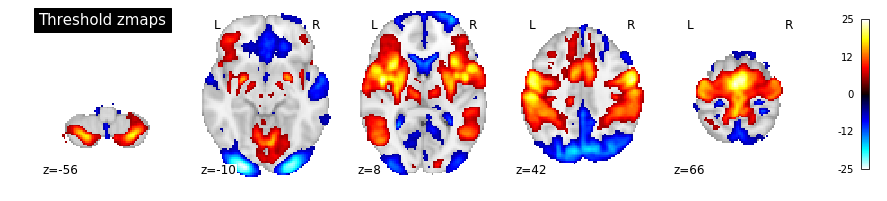

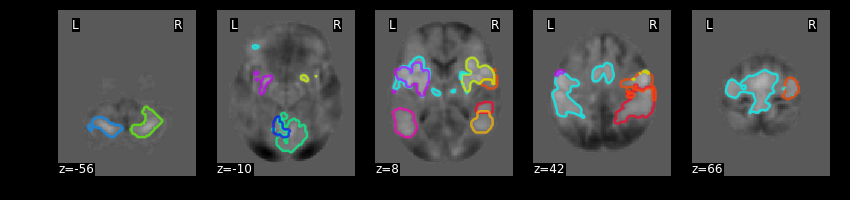

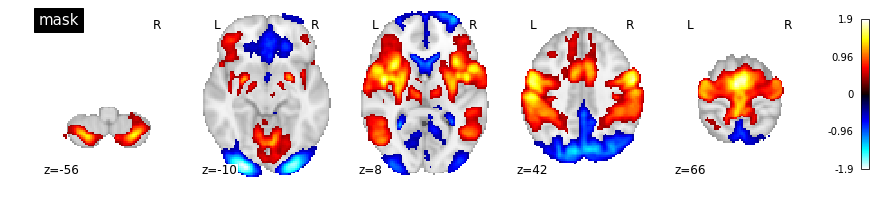

In [12]:
Act_zmaps = "/home/yuzhang/scratch/HCP/HCP_taskAct_Zmaps/tfMRI_MOTOR_AVG_zstat1.nii.gz"
thre_Act_zmaps = image.threshold_img(Act_zmaps, threshold=5.0)

plotting.plot_stat_map(Act_zmaps, display_mode='z', cut_coords=5,title='zmaps', colorbar=True)

# Showing intensity threshold image
plotting.plot_stat_map(thre_Act_zmaps, display_mode='z', cut_coords=5,title='Threshold zmaps', colorbar=True)

from nilearn import regions
regions_zmaps, index = regions.connected_regions(thre_Act_zmaps,min_region_size=1500)
plotting.plot_prob_atlas(regions_zmaps, bg_img=Act_zmaps,view_type='contours', display_mode='z',cut_coords=5)

fmri_data_clean = image.clean_img(fmri_files[0], detrend=True, standardize=True, confounds=confound,mask_img=brainmask)
masked_data = np.transpose(masking.apply_mask(fmri_data_clean, brainmask),(1,0))
print(masked_data.shape)

(1, 91, 109, 91)
(91, 109, 91)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


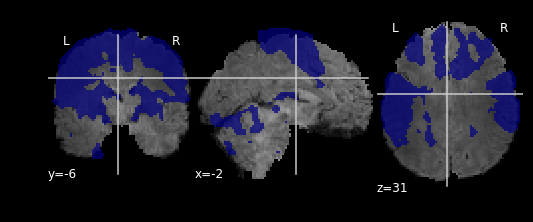

In [22]:
thre_Act_zmaps = image.threshold_img(Act_zmaps, threshold=5.0)
zvalues = [image.load_img(Act_zmaps).get_data()>5.0]
print(np.array(zvalues).shape)
print(np.squeeze(np.array(zvalues), axis=0).shape)

mask_img = image.new_img_like(Act_zmaps,np.squeeze(np.array(zvalues), axis=0).astype(np.int))

plotting.plot_roi(mask_img, image.mean_img(fmri_files[0]))

In [22]:
from sklearn import svm, metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score

###################
##whether the motion parameters are informative
confound = np.loadtxt(confound_files[0])
min_max_scaler = preprocessing.MinMaxScaler()
masked_data = min_max_scaler.fit_transform(confound)
print(masked_data.shape)

###############
#target_name = ['hand', 'foot','tongue']
trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
###use each slice along z-axis as one sample
label_data_trial = np.array(label_trials.loc[trial_mask])
masked_data_trial = np.array(masked_data[trial_mask])

########################
X_data = masked_data_trial
Y_data = label_data_trial
print(X_data.shape, Y_data.shape)

n_classes = len(np.unique(Y_data))
target_name = np.unique(Y_data)
print(target_name)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=10)
clf = svm.SVC(kernel='linear', decision_function_shape='ovo')
clf.fit(X_train, Y_train)
acc = metrics.accuracy_score(clf.predict(X_test), Y_test)
# print(acc)

##f1 score for multiclass
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_train_int = le.transform(Y_train)
Y_test_int = le.transform(Y_test)
# print(np.unique(Y_train_int))

clf2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo',random_state=10)
scores = cross_val_score(clf2, X_train, Y_train_int, cv=5,scoring='accuracy')
print("cross-validation scores:",scores)

clf.fit(X_train, Y_train_int)
f1score = metrics.f1_score(clf.predict(X_test), Y_test_int, average='macro')
print('Accuarcy on test data: %4f and f1-score %4f' % (acc, f1score))
y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test_int, y_pred, target_names=target_name))
print('Confusion Matrix:')
print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))

(405, 12)
(316, 12) (316,)
['body' 'face' 'place' 'tool']
cross-validation scores: [0.61538462 0.54901961 0.56862745 0.48979592 0.6122449 ]
Accuarcy on test data: 0.578125 and f1-score 0.491536
             precision    recall  f1-score   support

       body       0.39      0.92      0.55        13
       face       0.00      0.00      0.00        15
      place       0.70      0.94      0.80        17
       tool       0.90      0.47      0.62        19

avg / total       0.53      0.58      0.51        64

Confusion Matrix:
[[12  0  1  0]
 [ 8  0  6  1]
 [ 1  0 16  0]
 [10  0  0  9]]


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
from nilearn import signal
from sklearn import svm, metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
Act_zmaps = "/home/yuzhang/scratch/HCP/HCP_taskAct_Zmaps/tfMRI_WM_0BK_zstat1.nii.gz"

#########
flag_confound = 1
flag_region = 0

###################
if flag_confound == 1:
    confound = np.loadtxt(confound_files[0])
    #normed_matrix = normalize(confound[:,:], axis=0, norm='l2')
    #confound, R = np.linalg.qr(normed_matrix)
else:
    confound = np.ones((TrialNum,12), dtype=int)
if flag_region == 1:
    thre_Act_zmaps = image.threshold_img(Act_zmaps, threshold=5.0)
    zvalues = [image.load_img(Act_zmaps).get_data()>5.0]
    mask_img = image.new_img_like(Act_zmaps,np.squeeze(np.array(zvalues), axis=0).astype(np.int))
else:
    mask_img = masking.compute_epi_mask(fmri_files[0])
    
#fmri_data_clean = image.clean_img(fmri_files[0], detrend=False, standardize=False, confounds=confound,mask_img=mask_img)
fmri_data_clean = fmri_files[0]
masked_data = masking.apply_mask(fmri_data_clean, mask_img)

#masked_data = signal.clean(masked_data, detrend=False, standardize=True, confounds=confound)
min_max_scaler = preprocessing.MinMaxScaler()
masked_data = min_max_scaler.fit_transform(masked_data)
print(masked_data.shape)

###############
#target_name = ['hand', 'foot','tongue']
trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
###use each slice along z-axis as one sample
label_data_trial = np.array(label_trials.loc[trial_mask])
masked_data_trial = np.array(masked_data[trial_mask])

########################
X_data = masked_data_trial
Y_data = label_data_trial
print(X_data.shape, Y_data.shape)

n_classes = len(np.unique(Y_data))
target_name = np.unique(Y_data)
print(target_name)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=10)
clf = svm.SVC(kernel='linear', decision_function_shape='ovo')
clf.fit(X_train, Y_train)
acc = metrics.accuracy_score(clf.predict(X_test), Y_test)
# print(acc)

##f1 score for multiclass
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_train_int = le.transform(Y_train)
Y_test_int = le.transform(Y_test)
# print(np.unique(Y_train_int))

clf2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo',random_state=10)
scores = cross_val_score(clf2, X_train, Y_train_int, cv=5,scoring='accuracy')
print("cross-validation scores:",scores)

clf.fit(X_train, Y_train_int)
f1score = metrics.f1_score(clf.predict(X_test), Y_test_int, average='macro')
print('Accuarcy on test data: %4f and f1-score %4f' % (acc, f1score))
y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test_int, y_pred, target_names=target_name))
print('Confusion Matrix:')
print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))

(284, 215176)
(180, 215176) (180,)
['foot' 'hand' 'tongue']
cross-validation scores: [0.7        0.82758621 0.82758621 0.89655172 0.7037037 ]
Accuarcy on test data: 0.833333 and f1-score 0.870833
             precision    recall  f1-score   support

       foot       0.93      0.72      0.81        18
       hand       0.71      0.92      0.80        13
     tongue       1.00      1.00      1.00         5

avg / total       0.86      0.83      0.83        36

Confusion Matrix:
[[13  5  0]
 [ 1 12  0]
 [ 0  0  5]]


In [18]:
##notes: 0.32 if using 12 motions, 0.35 if using 6 motions, 0.61 if using 3 motions
##without using motion->0.68; using raw image->0.97; 
##without using taskmask->0.29, 0.32, 0.57, 0.67, 0.89
##without using detrend and motion ->  0.89
#####to conclude: not using motion parameters

from sklearn.model_selection import cross_val_score
clf2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo',random_state=10)
scores = cross_val_score(clf2, X_train, Y_train_int, cv=5,scoring='accuracy')
print(scores)

clf2.fit(X_train, Y_train_int)
f1score = metrics.f1_score(clf2.predict(X_test), Y_test_int, average='macro')
print('Accuarcy on test data: %4f and f1-score %4f' % (acc, f1score))
y_pred = clf2.predict(X_test)
print(metrics.classification_report(Y_test_int, y_pred, target_names=target_name))
print('Confusion Matrix:')
print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))

[0.86538462 0.84313725 0.84313725 0.89795918 0.85714286]
Accuarcy on test data: 0.937500 and f1-score 0.934674
             precision    recall  f1-score   support

       body       0.86      0.92      0.89        13
       face       0.94      1.00      0.97        15
      place       0.94      0.88      0.91        17
       tool       1.00      0.95      0.97        19

avg / total       0.94      0.94      0.94        64

Confusion Matrix:
[[12  0  1  0]
 [ 0 15  0  0]
 [ 1  1 15  0]
 [ 1  0  0 18]]


In [8]:
events_all_subjects_file = "/home/yuzhang/scratch/HCP/temp_res/MOTOR_event_labels_1200R_test_ALL.h5"

subjects_trial_label_matrix = pd.read_hdf(events_all_subjects_file, 'trials')
subjects_trial_label_matrix = subjects_trial_label_matrix.values.tolist()
sub_name = pd.read_hdf(events_all_subjects_file, 'subject')
coding_direct = pd.read_hdf(events_all_subjects_file, 'coding')

print("Data samples including %d event files consisting of %d subjects, each has %d coding directions and %d trials \n\n"
      % (len(sub_name), len(np.unique(sub_name)), np.ceil(len(coding_direct)/len(np.unique(sub_name))), np.array(subjects_trial_label_matrix).shape[1]))


/home/yuzhang/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Data samples including 2145 event files consisting of 1075 subjects, each has 2 coding directions and 284 trials 




In [9]:
from tensorpack.utils.serialize import dumps, loads
import lmdb
lmdb_filename = "/home/yuzhang/scratch/HCP/temp_res/MOTOR_MMP_ROI_act_1200R_test_ALL.lmdb"

## read lmdb matrix
print('loading data from file: %s' % lmdb_filename)
matrix_dict = []
fmri_sub_name = []
lmdb_env = lmdb.open(lmdb_filename, subdir=False)
try:
    lmdb_txn = lmdb_env.begin()
    listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
    listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
    print('Stored fmri data from files:')
    print(len(listed_fmri_files))
except:
    print('Search each key for every fmri file...')

with lmdb_env.begin() as lmdb_txn:
    cursor = lmdb_txn.cursor()
    for key, value in cursor:
        #print(key)
        if key == b'__keys__':
            continue
        pathsub = Path(os.path.dirname(key.decode("utf-8")))
        if any('REST' in string for string in lmdb_filename.split('_')):
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
        else:
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
        data = loads(lmdb_txn.get(key))
        if any('REST' in string for string in lmdb_filename.split('_')):
            if data is None or data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
                del fmri_sub_name[-1]
            else:
                matrix_dict.append(np.array(data))
        else:
            matrix_dict.append(np.array(data))
lmdb_env.close()

subjects_tc_matrix = matrix_dict
print(np.array(subjects_tc_matrix).shape)
print(subjects_tc_matrix[0].shape)

/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:875: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/backend.py:4622: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/yuzhang/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.deco

Instructions for updating:
Use the retry module or similar alternatives.


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


loading data from file: /home/yuzhang/scratch/HCP/temp_res/MOTOR_MMP_ROI_act_1200R_test_ALL.lmdb
Search each key for every fmri file...


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/msgpack_numpy.py:77: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


(2145,)
(284, 360)


In [10]:
def preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix, fmri_sub_name):
    print("Pre-clean the fmri and event data to make sure the matching shapes between two arrays!")
    Subject_Num = np.array(subjects_tc_matrix).shape[0]
    Trial_Num, Region_Num = subjects_tc_matrix[0].shape
    if np.array(subjects_trial_label_matrix).shape[0] != Subject_Num:
        print('Warning: Mis-matching subjects list between fmri-data-matrix and trial-label-matrix')
        print(np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)

    for subj in range(Subject_Num):
        try:
            tsize, rsize = subjects_tc_matrix[subj].shape
        except:
            print(subj==Subject_Num-1)
            print('The end of SubjectList...\n')
        if tsize != Trial_Num:
            print('Remove subject: %s due to different trial num: %d in the fmri data' % (fmri_sub_name[subj],tsize))
            del subjects_tc_matrix[subj]
            del subjects_trial_label_matrix[subj]
        if rsize != Region_Num:
            print('Remove subject: %s due to different region num: %d in the fmri data' % (fmri_sub_name[subj],rsize))
            del subjects_tc_matrix[subj]
            del subjects_trial_label_matrix[subj]

    print('Done matching data shapes:',np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)
    return subjects_tc_matrix, subjects_trial_label_matrix

In [11]:
subjects_tc_matrix = matrix_dict
subname_coding = fmri_sub_name
print(np.array(subjects_tc_matrix).shape)
print(subjects_tc_matrix[0].shape)

subjects_tc_matrix_new, subjects_trial_label_matrix_new = preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix,subname_coding)
Subject_Num = np.array(subjects_tc_matrix_new).shape[0]
print(np.array(subjects_trial_label_matrix_new).shape)
print(np.array(subjects_tc_matrix_new).shape)
print(np.unique(subjects_trial_label_matrix_new))

(2145,)
(284, 360)
Pre-clean the fmri and event data to make sure the matching shapes between two arrays!
Remove subject: 689470_RL due to different trial num: 272 in the fmri data
True
The end of SubjectList...

Done matching data shapes: (2144, 284, 360) (2144, 284)
(2144, 284)
(2144, 284, 360)
['foot_mot' 'hand_mot' 'rest' 'tongue_mot']


In [12]:
from sklearn import svm, metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, DictionaryLearning, KernelPCA

sub_num = 200
Flag_PCA = 1
my_comp = 10; my_cv_fold=5
block_dura = 18

Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix_new).shape
fmri_data = np.array(subjects_tc_matrix_new[:Subject_Num])
label_data = np.array(subjects_trial_label_matrix_new[:Subject_Num])
print("%d Data samples with %d features for each" % (fmri_data.shape[0], fmri_data.shape[-1]))

fmri_data_matrix = []
label_data_matrix = []
for subi in range(Subject_Num):
    label_trial_data = np.array(subjects_trial_label_matrix_new[subi])
    condition_mask = pd.Series(label_trial_data).str.split('_',expand = True)[0].isin(target_name)
    fmri_data_matrix.append(subjects_tc_matrix_new[subi][condition_mask,:])
    label_data_matrix.append(label_trial_data[condition_mask])

fmri_data_matrix = np.array(fmri_data_matrix)
label_data_matrix = np.array(label_data_matrix)

##cut the trials into blocks
chunks = int(np.floor(label_data_matrix.shape[-1]/block_dura))
fmri_data_block = np.array(np.array_split(fmri_data_matrix,chunks,axis=1)).mean(axis=2)
label_data_block = np.array(np.array_split(label_data_matrix,chunks,axis=1))[:,:,0]


###reshape data to fit the model
X_data = np.vstack(fmri_data_block[:,:sub_num,:]).astype('float32',casting='same_kind')
Y_data = label_data_block[:,:sub_num].ravel()
###Y_data = np.vstack(np.repeat(np.expand_dims(label_data_block[:,:100],axis=2),Region_Num,axis=2))[:,0]
print(X_data.shape,Y_data.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=10)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype('float32',casting='same_kind')
X_test = scaler.transform(X_test).astype('float32',casting='same_kind')
n_classes = len(np.unique(label_data_block))
le = preprocessing.LabelEncoder()
le.fit(np.unique(Y_data))
Y_train_int = le.transform(Y_train)
Y_test_int = le.transform(Y_test)

########training a svm classifier
clf2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo',random_state=10)
scores = cross_val_score(clf2, X_train, Y_train_int, cv=5,scoring='accuracy')
print("cross-validation scores:",scores)

clf = svm.SVC(kernel='linear', decision_function_shape='ovo',random_state=10)
clf.fit(X_train, Y_train_int)
acc = metrics.accuracy_score(clf.predict(X_test), Y_test_int)

clf.fit(X_train, Y_train_int)
f1score = metrics.f1_score(clf.predict(X_test), Y_test_int, average='macro')
print('Accuarcy on test data: %4f and f1-score %4f' % (acc, f1score))
y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test_int, y_pred, target_names=target_name))
print('Confusion Matrix:')
print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))

if Flag_PCA:
    ##using pca for dimension reduction
    pca = PCA(n_components=my_comp, svd_solver='randomized', whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    #clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
    scores_pca = cross_val_score(clf, X_train_pca, Y_train_int, cv=my_cv_fold, scoring='accuracy')
    print('SVM Scoring after PCA decomposition: ')
    print(scores_pca)

    ##using fastica for dimension reduction
    ica = FastICA(n_components=my_comp, whiten=True)
    X_train_ica = ica.fit_transform(X_train)
    #clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
    scores_ica = cross_val_score(clf, X_train_ica, Y_train_int, cv=my_cv_fold, scoring='accuracy')
    print('SVM Scoring after ICA decomposition: ')
    print(scores_ica)

    ##using kernelPCA for dimension reduction
    kpca = KernelPCA(n_components=my_comp, kernel='rbf')
    X_train_kpca = kpca.fit_transform(X_train)
    #clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
    scores_kpca = cross_val_score(clf, X_train_kpca, Y_train_int, cv=my_cv_fold, scoring='accuracy')
    print('SVM Scoring after DL decomposition: ')
    print(scores_kpca)

2144 Data samples with 360 features for each
(2000, 360) (2000,)
cross-validation scores: [0.57943925 0.61682243 0.63239875 0.61128527 0.60062893]
Accuarcy on test data: 0.680000 and f1-score 0.629521
             precision    recall  f1-score   support

       foot       0.70      0.74      0.72       152
       hand       0.77      0.72      0.75       181
     tongue       0.42      0.43      0.43        67

avg / total       0.68      0.68      0.68       400

Confusion Matrix:
[[112  21  19]
 [ 29 131  21]
 [ 20  18  29]]
SVM Scoring after PCA decomposition: 
[0.37694704 0.38629283 0.40498442 0.44827586 0.40251572]
SVM Scoring after ICA decomposition: 
[0.40498442 0.40498442 0.40498442 0.40438871 0.40566038]
SVM Scoring after DL decomposition: 
[0.39563863 0.40186916 0.3894081  0.40438871 0.40880503]


In [21]:
def my_svc_simple(subjects_tc_matrix,subjects_trial_label_matrix,target_name,sub_num=None, block_dura=18, Flag_PCA=1, my_cv_fold=10,my_comp=20):
    ###using svm for classification with each trial/time as one sample

    Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix).shape
    if Trial_Num != np.array(subjects_trial_label_matrix).shape[1]:
        print('Miss-matching trial infos for event and fmri data')
    if Subject_Num != np.array(subjects_trial_label_matrix).shape[0]:
        print('Adjust subject numbers for event data')
        subjects_trial_label_matrix = np.array(subjects_trial_label_matrix[:Subject_Num])
    else:
        subjects_trial_label_matrix = np.array(subjects_trial_label_matrix)

    ###SVM classifier
    ##feature matrix
    if not sub_num:
        sub_num = Subject_Num
    if not block_dura:
        block_dura = 18 ###12s block for MOTOR task
    print("%d Data samples with %d trials and %d features for each" % (sub_num, Trial_Num, Region_Num))

    fmri_data_matrix = []
    label_data_matrix = []
    for subi in range(Subject_Num):
        label_trial_data = np.array(subjects_trial_label_matrix[subi])
        condition_mask = pd.Series(label_trial_data).str.split('_',expand = True)[0].isin(target_name)
        fmri_data_matrix.append(subjects_tc_matrix[subi][condition_mask,:])
        label_data_matrix.append(label_trial_data[condition_mask])
    fmri_data_matrix = np.array(fmri_data_matrix).astype('float32',casting='same_kind')
    label_data_matrix = np.array(label_data_matrix)

    ##cut the trials into blocks
    chunks = int(np.floor(label_data_matrix.shape[-1] / block_dura))
    fmri_data_block = np.array(np.array_split(fmri_data_matrix, chunks, axis=1)).mean(axis=2).astype('float32',casting='same_kind')
    label_data_block = np.array(np.array_split(label_data_matrix, chunks, axis=1))[:, :, 0]

    ###reshape data to fit the model
    X_data = np.vstack(fmri_data_block[:, :sub_num, :]).astype('float32', casting='same_kind')
    Y_data = label_data_block[:, :sub_num].ravel()
    ###Y_data = np.vstack(np.repeat(np.expand_dims(label_data_block[:,:100],axis=2),Region_Num,axis=2))[:,0]
    print(X_data.shape, Y_data.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=10)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).astype('float32', casting='same_kind')
    X_test = scaler.transform(X_test).astype('float32', casting='same_kind')
    n_classes = len(np.unique(label_data_block))
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(Y_data))
    Y_train_int = le.transform(Y_train)
    Y_test_int = le.transform(Y_test)

    ########training a svm classifier
    clf2 = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
    scores = cross_val_score(clf2, X_train, Y_train_int, cv=5, scoring='accuracy')
    print("cross-validation scores:", scores)

    clf = svm.SVC(kernel='linear', decision_function_shape='ovo', random_state=10)
    clf.fit(X_train, Y_train_int)
    acc = metrics.accuracy_score(clf.predict(X_test), Y_test_int)

    clf.fit(X_train, Y_train_int)
    f1score = metrics.f1_score(clf.predict(X_test), Y_test_int, average='macro')
    print('Accuarcy on test data: %4f and f1-score %4f' % (acc, f1score))
    y_pred = clf.predict(X_test)
    print(metrics.classification_report(Y_test_int, y_pred, target_names=target_name))
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))

    if Flag_PCA:
        ##using pca for dimension reduction
        pca = PCA(n_components=my_comp, svd_solver='randomized', whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        # clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
        scores_pca = cross_val_score(clf, X_train_pca, Y_train_int, cv=my_cv_fold, scoring='accuracy')
        print('SVM Scoring after PCA decomposition: ')
        print(scores_pca)

        ##using fastica for dimension reduction
        ica = FastICA(n_components=my_comp, whiten=True)
        X_train_ica = ica.fit_transform(X_train)
        # clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
        scores_ica = cross_val_score(clf, X_train_ica, Y_train_int, cv=my_cv_fold, scoring='accuracy')
        print('SVM Scoring after ICA decomposition: ')
        print(scores_ica)

        ##using kernelPCA for dimension reduction
        kpca = KernelPCA(n_components=my_comp, kernel='rbf')
        X_train_kpca = kpca.fit_transform(X_train)
        # clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=10)
        scores_kpca = cross_val_score(clf, X_train_kpca, Y_train_int, cv=my_cv_fold, scoring='accuracy')
        print('SVM Scoring after DL decomposition: ')
        print(scores_kpca)

    return scores, scores_pca, scores_ica, scores_kpca


##to run svm
sub_num = 500
scores, scores_pca, scores_ica, scores_kpca = my_svc_simple(subjects_tc_matrix_new, subjects_trial_label_matrix_new, target_name,sub_num=sub_num, my_cv_fold=5, my_comp=10)

500 Data samples with 284 trials and 360 features for each
(5000, 360) (5000,)
cross-validation scores: [0.53308365 0.53308365 0.5525     0.555      0.53258145]
Accuarcy on test data: 0.530000 and f1-score 0.474559
             precision    recall  f1-score   support

       foot       0.54      0.60      0.57       396
       hand       0.57      0.62      0.60       403
     tongue       0.34      0.21      0.26       201

avg / total       0.51      0.53      0.52      1000

Confusion Matrix:
[[238 106  52]
 [122 250  31]
 [ 79  80  42]]
SVM Scoring after PCA decomposition: 
[0.42696629 0.41697878 0.42       0.43125    0.41353383]
SVM Scoring after ICA decomposition: 
[0.40074906 0.40074906 0.40125    0.40125    0.40100251]
SVM Scoring after DL decomposition: 
[0.40948814 0.40324594 0.44       0.4175     0.42481203]


In [76]:
def subject_cross_validation_split_trials(tc_matrix, label_matrix, sub_num=None, n_folds=10, testsize=0.2, valsize=0.1, randomseed=1234):
    ##randomseed=1234;testsize = 0.2;n_folds=10;valsize=0.1
    Subject_Num, Trial_Num,Region_Num = np.array(tc_matrix).shape

    rs = np.random.RandomState(randomseed)
    if not sub_num:
        sub_num = Subject_Num


    fmri_data_matrix = []
    label_data_matrix = []
    for subi in range(Subject_Num):
        label_trial_data = np.array(label_matrix[subi])
        condition_mask = pd.Series(label_trial_data).str.split('_',expand = True)[0].isin(target_name)
        fmri_data_matrix.append(tc_matrix[subi][condition_mask,:])
        label_data_matrix.append(label_trial_data[condition_mask])
    fmri_data_matrix = np.array(fmri_data_matrix).astype('float32',casting='same_kind')
    label_data_matrix = np.array(label_data_matrix)
    ##cut the trials into blocks
    chunks = int(np.floor(label_data_matrix.shape[-1] / block_dura))
    fmri_data_block = np.array(np.array_split(fmri_data_matrix, chunks, axis=1)).mean(axis=2).astype('float32',casting='same_kind')
    label_data_block = np.array(np.array_split(label_data_matrix, chunks, axis=1))[:, :, 0]
    #print(fmri_data_block.shape,label_data_block.shape)

    train_sid_tmp, test_sid = train_test_split(range(sub_num), test_size=testsize, random_state=rs, shuffle=True)
    fmri_data_train = np.array([fmri_data_block[:,i,:] for i in train_sid_tmp]).astype('float32', casting='same_kind')
    fmri_data_test = np.array([fmri_data_block[:,i,:] for i in test_sid]).astype('float32', casting='same_kind')
    #print(fmri_data_train.shape,fmri_data_test.shape)

    label_data_train = np.array([label_data_block[:,i] for i in train_sid_tmp])
    label_data_test = np.array([label_data_block[:,i] for i in test_sid])
    #print(label_data_train.shape,label_data_test.shape)

    ###transform the data
    scaler = preprocessing.StandardScaler().fit(np.vstack(fmri_data_train))
    ##fmri_data_train = scaler.transform(fmri_data_train)
    X_test = scaler.transform(np.vstack(fmri_data_test))
    nb_class = len(np.unique(label_data_block))
    Y_test = label_data_test.ravel()
    #print(X_test.shape,Y_test.shape)

    from sklearn.model_selection import ShuffleSplit
    valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
    X_train_scaled = []
    X_val_scaled = []
    Y_train_scaled = []
    Y_val_scaled = []
    for train_sid, val_sid in valsplit.split(train_sid_tmp):

        ##preprocess features and labels
        X = np.array(np.vstack([fmri_data_train[i,:,:] for i in train_sid]))
        Y = np.array([label_data_train[i,:] for i in train_sid]).ravel()
        #print(X.shape, Y.shape)
        X_train_scaled.append(scaler.transform(X))
        Y_train_scaled.append(Y)

        X = np.array(np.vstack([fmri_data_train[i,:,:] for i in val_sid]))
        Y = np.array([label_data_train[i,:] for i in val_sid]).ravel()
        #print(X.shape, Y.shape)
        X_val_scaled.append(scaler.transform(X))
        Y_val_scaled.append(Y)

    print('Samples of Subjects for training: %d and testing %d and validating %d with %d classes' % (len(train_sid), len(test_sid), len(val_sid), nb_class))
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test, Y_test

    
##########################################
def my_svc_simple_subject_validation_new(subjects_tc_matrix,subjects_trial_label_matrix,sub_num=None,my_cv_fold=10,my_comp=20,my_testsize=0.2,my_valsize=0.2):

    ##test for svm classification
    #my_cv_fold=10;my_testsize = 0.2;my_valsize=0.1
    #sub_num=100
    import time

    Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix_new).shape
    if Trial_Num != np.array(subjects_trial_label_matrix_new).shape[1]:
        print('Miss-matching trial infos for event and fmri data')
    if Subject_Num != np.array(subjects_trial_label_matrix_new).shape[0]:
        print('Adjust subject numbers for event data')
        subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new[:Subject_Num])
    else:
        subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new)

    if not sub_num:
        sub_num = Subject_Num

    ###SVM classifier
    ##split data into train, val and test in subject-level
    X_train, Y_train, X_val, Y_val, X_test, Y_test = \
    subject_cross_validation_split_trials(subjects_tc_matrix_new, subjects_trial_label_matrix,sub_num=sub_num)

    ##build a simple classifier using SVM
    print('Training the model using multi-class svc')
    clf = svm.SVC(kernel='linear', decision_function_shape='ovo', random_state=10)
    train_acc = []
    val_acc = []
    for x_train, y_train, x_val, y_val, cvi in zip(X_train, Y_train, X_val, Y_val, range(my_cv_fold)):
        print('cv-fold: %d ...' % cvi)
        start_time = time.clock()
        clf.fit(x_train, y_train)
        train_acc.append(metrics.accuracy_score(clf.predict(x_train), y_train))
        val_acc.append(metrics.accuracy_score(clf.predict(x_val), y_val))
        #print('Time Usage of model training in seconds: {0:.2f} '.format(time.clock() - start_time))
    ##print(train_acc,val_acc)


    X_train_all = np.array(np.vstack((X_train[0],X_val[0])))
    Y_train_all = np.array(np.concatenate((Y_train[0],Y_val[0]), axis=0))
    print('sample size for training and testing: ',X_train_all.shape,Y_train_all.shape)
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(Y_train_all))
    Y_train_int = le.transform(Y_train_all)
    Y_test_int = le.transform(Y_test)

    clf = svm.SVC(kernel='linear', decision_function_shape='ovo', random_state=10)
    clf.fit(X_train_all, Y_train_int)
    y_pred = clf.predict(X_test)
    print(metrics.classification_report(Y_test_int, y_pred, target_names=np.unique(Y_test)))
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(len(np.unique(Y_test)))))
    
    test_acc = metrics.accuracy_score(y_pred, Y_test_int)
    scores = [np.mean(train_acc),np.mean(val_acc),test_acc]
    print('SVM Scoring:')
    print("Accuracy of prediction in training:{},validation:{} and testing:{}"
          .format(scores[0], scores[1], scores[2]))
    
    return scores

###runing for svm
scores=my_svc_simple_subject_validation_new(subjects_tc_matrix_new,subjects_trial_label_matrix_new,sub_num=200)

Samples of Subjects for training: 144 and testing 40 and validating 16 with 3 classes
Training the model using multi-class svc
cv-fold: 0 ...
cv-fold: 1 ...
cv-fold: 2 ...
cv-fold: 3 ...
cv-fold: 4 ...
cv-fold: 5 ...
cv-fold: 6 ...
cv-fold: 7 ...
cv-fold: 8 ...
cv-fold: 9 ...
sample size for training and testing:  (1600, 360) (1600,)
             precision    recall  f1-score   support

   foot_mot       0.50      0.57      0.53       160
   hand_mot       0.53      0.52      0.53       160
 tongue_mot       0.42      0.31      0.36        80

avg / total       0.50      0.50      0.50       400

Confusion Matrix:
[[92 50 18]
 [61 83 16]
 [32 23 25]]
SVM Scoring:
Accuracy of prediction in training:0.9374305555555555,validation:0.44312500000000005 and testing:0.5


In [66]:
#print(np.concatenate((Y_train[0],Y_val[0]), axis=0))

X_train_all = np.array(np.vstack((X_train[0],X_val[0])))
Y_train_all = np.array(np.concatenate((Y_train[0],Y_val[0]), axis=0))
print(X_train_all.shape,Y_train_all.shape)
le = preprocessing.LabelEncoder()
le.fit(np.unique(Y_train_all))
Y_train_int = le.transform(Y_train_all)
Y_test_int = le.transform(Y_test)
    
clf.fit(X_train_all, Y_train_int)
y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test_int, y_pred, target_names=np.unique(Y_test)))
print('Confusion Matrix:')
print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(len(np.unique(Y_test)))))


(800, 360) (800,)
             precision    recall  f1-score   support

   foot_mot       0.46      0.49      0.47        80
   hand_mot       0.44      0.64      0.52        80
 tongue_mot       0.00      0.00      0.00        40

avg / total       0.36      0.45      0.40       200

Confusion Matrix:
[[39 41  0]
 [29 51  0]
 [17 23  0]]


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
nr_thread=5
buffer_size=10
target_name = np.unique(list(task_contrasts.values()))
print(target_name)
from keras.utils import to_categorical
import time

def data_pipe(fmri_files,confound_files,label_matrix,target_name=None,batch_size=32,data_type='train',
              train_percent=0.8,nr_thread=nr_thread,buffer_size=buffer_size):
    assert data_type in ['train', 'val', 'test']
    assert fmri_files is not None
    
    print('Generating dataflow for %s datasets \n' % data_type)
    
    buffer_size = min(len(fmri_files),buffer_size)
    nr_thread = min(len(fmri_files),nr_thread)
    
    ds0 = gen_fmri_file(fmri_files,confound_files, label_matrix,data_type=data_type,train_percent=train_percent)
    print('dataflowSize is ' + str(ds0.size()))
    print('Loading data using %d threads with %d buffer_size ... \n' % (nr_thread, buffer_size))
    
    if target_name is None:
        target_name = np.unique(label_matrix)
    
    ####running the model
    start_time = time.clock()
    ds1 = dataflow.MultiThreadMapData(
        ds0, nr_thread=nr_thread,
        map_func=lambda dp: map_load_fmri_image(dp,target_name),
        buffer_size=buffer_size,
        strict=True)

    ds1 = dataflow.PrefetchData(ds1, buffer_size,1)
    
    ds1 = split_samples(ds1)
    print('prefetch dataflowSize is ' + str(ds1.size()))
    
    ds1 = dataflow.LocallyShuffleData(ds1,buffer_size=ds1.size()*buffer_size)
        
    ds1 = dataflow.BatchData(ds1,batch_size=batch_size)
    print('Time Usage of loading data in seconds: {} \n'.format(time.clock() - start_time))
    
    ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
    ds1._reset_once()
    ##ds1.reset_state()
    
    #return ds1.get_data()
    for df in ds1.get_data():
        ##print(np.expand_dims(df[0].astype('float32'),axis=3).shape)
        yield (np.expand_dims(df[0].astype('float32'),axis=3),to_categorical(df[1].astype('int32'),len(target_name)))
        
    '''
    df = ds1
    assert isinstance(df, dataflow.DataFlow), type(df)
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0

    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys = []
        data = []
        for idx, dp in enumerate(df.get_data()):
            keystr = u'{}'.format(dp[0]).encode('ascii')
            data.append(dp[1].astype('float32'))
            #txn.put(keystr, dumps(dp[1].astype('float32')))  ##change datatype to float32
            pbar.update()
            print(idx, keystr)
    return data
    '''

['foot' 'hand' 'tongue']


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(model_history):
    plt.figure()
    plt.subplot(121)
    plt.plot(model_history.history['acc'], color='r')
    #plt.plot(model_history.history['val_acc'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.legend(['Training', 'Validation'])

    plt.subplot(122)
    plt.plot(model_history.history['loss'], color='r')
    #plt.plot(model_history.history['val_loss'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')
    #plt.legend(['Training', 'Validation'])

    return None

#plot_history(model_test_history)

In [9]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization, AveragePooling2D
from keras.models import Model
import keras.backend as K

#keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)


def build_cnn_model(input_shape, Nlabels, filters=32, convsize=3, poolsize=2, hidden_size=128, conv_layers=4):
    #     import keras.backend as K
    #     if K.image_data_format() == 'channels_first':
    #         img_shape = (1,img_rows,img_cols)
    #     elif K.image_data_format() == 'channels_last':
    #         img_shape = (img_rows,img_cols,1)


    input0 = Input(shape=input_shape)
    drop1 = input0
    for li in range(conv_layers):
        conv1 = Conv2D(filters, (convsize, convsize), padding='same', activation='relu')(drop1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(filters, (convsize, convsize), padding='same', activation='relu')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D((poolsize, poolsize))(conv1)
        drop1 = Dropout(0.25)(pool1)
        if (li+1) % 2 ==0:
            filters *= 2


    drop2 = drop1
    avg1=AveragePooling2D(pool_size=(5, 5))(drop2)
    flat = Flatten()(avg1)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    #hidden = Dense((hidden_size/4).astype(int), activation='relu')(drop3)
    #drop4 = Dropout(0.5)(hidden)
    
    out = Dense(Nlabels, activation='softmax')(drop3)

    model = Model(inputs=input0, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model


#####################
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, AveragePooling3D
from keras.models import Model

def build_cnn3d_model(input_shape,Nlabels,filters=32,convsize=3,poolsize=2,hidden_size=128, conv_layers=4):
    
#     import keras.backend as K
#     if K.image_data_format() == 'channels_first':
#         img_shape = (1,img_rows,img_cols)
#     elif K.image_data_format() == 'channels_last':
#         img_shape = (img_rows,img_cols,1)
    
    
    input0 = Input(shape=input_shape)
    drop1 = input0
    for li in range(conv_layers):
        conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(drop1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling3D((poolsize,poolsize,poolsize))(conv1)
        drop1 = Dropout(0.25)(pool1)
        if (li+1) % 2 ==0:
            filters *= 2

    drop2 = drop1
    avg1=AveragePooling3D(pool_size=(5,5,5))(drop2)
    flat = Flatten()(avg1)
    hidden = Dense(hidden_size,activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    
    out = Dense(Nlabels,activation='softmax')(drop3)
    
    model = Model(inputs=input0,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

#####
nb_class = len(target_name)
tc_matrix = nib.load(fmri_files[0])
img_rows, img_cols, img_deps = tc_matrix.shape[:-1]
img_shape = []
if K.image_data_format() == 'channels_first':
    img_shape = (1, img_rows, img_cols, img_deps)
elif K.image_data_format() == 'channels_last':
    img_shape = (img_rows, img_cols, img_deps,  1)

model_test = build_cnn3d_model(img_shape, nb_class)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 91, 109, 91, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 91, 109, 91, 32)   896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 91, 109, 91, 32)   128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 91, 109, 91, 32)   27680     
_________________________________________________________________
batch_normalization_2 (Batch (None, 91, 109, 91, 32)   128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 45, 54, 45, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 54, 45, 32)    0         
__________

In [10]:

#####
nb_class = len(target_name)
tc_matrix = nib.load(fmri_files[0])
img_rows, img_cols, img_deps = tc_matrix.shape[:-1]
img_shape = []
if K.image_data_format() == 'channels_first':
    img_shape = (1, img_rows, img_cols)
elif K.image_data_format() == 'channels_last':
    img_shape = (img_rows, img_cols, 1)

####################
##start cnn model
model_test = build_cnn_model(img_shape, nb_class)
test_sub_num = len(fmri_files)
train_gen = data_pipe(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
                      target_name=target_name,batch_size=16,data_type='train',buffer_size=10)
val_set = data_pipe(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
                    target_name=target_name,batch_size=16,data_type='test',buffer_size=10)
##xx = data_pipe(fmri_files,confound_files,label_matrix,target_name=target_name)
model_test_history = model_test.fit_generator(train_gen, epochs=10, steps_per_epoch=20, verbose=1, shuffle=True)
                                              #validation_data=val_set,validation_steps=10,
                                              #workers=1, use_multiprocessing=False, shuffle=False)
print(model_test_history.history)
#plot_history(model_test_history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 91, 109, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 109, 32)       320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 91, 109, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 91, 109, 32)       9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 91, 109, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 54, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 54, 32)        0         
__________

/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/131924_tfMRI_MOTOR_RL.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/123117_tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/192136_tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/104012_tfMRI_MOTOR_RL.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/188145_tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/102008_tfMRI_MOTOR_RL.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/126426_tfMRI_MOTOR_RL.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/117930_tfMRI_MOTOR_RL.nii.gz (16380, 91, 109) (16380,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI

Process _Worker-1:
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/tensorpack/dataflow/parallel.py", line 160, in run
    self.queue.put(dp)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/queues.py", line 82, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers

In [13]:
model_test_history = model_test.fit_generator(train_gen, epochs=100, steps_per_epoch=50, verbose=1, shuffle=True)
                                              #validation_data=val_set,validation_steps=10,
                                              #workers=1, use_multiprocessing=False, shuffle=False)
print(model_test_history.history)

Epoch 1/100
100/100 [==============================] - 2s 23ms/step - loss: 0.7228 - acc: 0.6275
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.6368 - acc: 0.6881
Epoch 3/100
 44/100 [============>.................] - ETA: 1s - loss: 0.6122 - acc: 0.6932

KeyboardInterrupt: 

In [ ]:
##val_set = data_pipe(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
##                    target_name=target_name,batch_size=16,data_type='test',buffer_size=5)
model_test_history = model_test.fit_generator(train_gen, epochs=10, steps_per_epoch=20, verbose=1, 
                                              validation_data=val_set,validation_steps=20,
                                              workers=1, use_multiprocessing=False, shuffle=False)
print(model_test_history.history)
plot_history(model_test_history)

Epoch 1/10
 4/20 [=====>........................] - ETA: 0s - loss: 0.7831 - acc: 0.5312

In [10]:
test_sub_num = 1000
tst=data_pipe(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
              target_name=target_name,batch_size=16,data_type='train',buffer_size=5)
out=next(tst)

##print(out[0])
print(out[0].shape)
print(out[1].shape)

Generating dataflow for train datasets 

dataflowSize is 800
Loading data using 5 threads with 5 buffer_size ... 

prefetch dataflowSize is 25844
Time Usage of loading data in seconds: 0.03312599999999577 

/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/130720/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/127731/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/571144/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/154229/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz (16380, 91, 109) (16380,)
/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/348545/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_L

adjust tensorpack codes for 3dcnn

In [10]:
nr_thread=5
buffer_size=10
target_name = np.unique(list(task_contrasts.values()))
print(target_name)
from keras.utils import to_categorical
import time

from nilearn import signal
from nilearn import image
from sklearn import preprocessing
from keras.utils import np_utils

from tensorpack import dataflow


class gen_fmri_file(dataflow.DataFlow):
    """ Iterate through fmri filenames, confound filenames and labels
    """
    def __init__(self, fmri_files,confound_files, label_matrix,data_type='train',train_percent=0.8):
        assert (len(fmri_files) == len(confound_files))
        # self.data=zip(fmri_files,confound_files)
        self.fmri_files = fmri_files
        self.confound_files = confound_files
        self.label_matrix = label_matrix
        
        self.data_type=data_type
        self.train_percent=train_percent

    def size(self):
        split_num=int(len(self.fmri_files)*0.8)
        if self.data_type=='train':
            return split_num
        else:
            return len(self.fmri_files)-split_num

    def get_data(self):
        split_num=int(len(self.fmri_files)*0.8)
        if self.data_type=='train':
            while True:
                rand_pos=np.random.choice(split_num,1)[0]
                yield self.fmri_files[rand_pos],self.confound_files[rand_pos],self.label_matrix.iloc[rand_pos]
        else:
            for pos_ in range(split_num,len(self.fmri_files)):
                yield self.fmri_files[pos_],self.confound_files[pos_],self.label_matrix.iloc[pos_]


class split_samples(dataflow.DataFlow):
    """ Iterate through fmri filenames, confound filenames and labels
    """
    def __init__(self, ds):
        self.ds=ds

    def size(self):
        return 91*284

    def get_data(self):
        for data in self.ds.get_data():
            for i in range(data[1].shape[0]):
                yield data[0][i],data[1][i]



def map_load_fmri_image_3d(dp,target_name):
    fmri_file=dp[0]
    confound_file=dp[1]
    label_trials=dp[2]
    
    ###remove confound effects
    confound = np.loadtxt(confound_files[0])
    fmri_data_clean = image.clean_img(fmri_files[0], detrend=True, standardize=True, confounds=confound)
    
    ##pre-select task types
    trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
    fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0]).get_data()
    ###use each slice along z-axis as one sample
    label_data_trial = np.array(label_trials.loc[trial_mask])
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    label_data_cnn = le.transform(label_data_trial) ##np_utils.to_categorical(): convert label vector to matrix

    img_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]
    fmri_data_cnn_test = np.transpose(fmri_data_cnn, (3, 0, 1,2))
    label_data_cnn_test = label_data_cnn.flatten()
    print(fmri_file, fmri_data_cnn_test.shape,label_data_cnn_test.shape)
    
    return fmri_data_cnn_test, label_data_cnn_test

          
def map_load_fmri_image(dp,target_name):
    fmri_file=dp[0]
    confound_file=dp[1]
    label_trials=dp[2]
    
    ###remove confound effects
    confound = np.loadtxt(confound_files[0])
    fmri_data_clean = image.clean_img(fmri_files[0], detrend=True, standardize=True, confounds=confound)
    
    ##pre-select task types
    trial_mask = pd.Series(label_trials).isin(target_name)  ##['hand', 'foot','tongue']
    fmri_data_cnn = image.index_img(fmri_data_clean, np.where(trial_mask)[0]).get_data()
    ###use each slice along z-axis as one sample
    label_data_trial = np.array(label_trials.loc[trial_mask])
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    label_data_cnn = le.transform(label_data_trial) ##np_utils.to_categorical(): convert label vector to matrix

    img_rows, img_cols, img_deps = fmri_data_cnn.shape[:-1]
    fmri_data_cnn_test = np.transpose(fmri_data_cnn.reshape(img_rows, img_cols, np.prod(fmri_data_cnn.shape[2:])), (2, 0, 1))
    label_data_cnn_test = np.repeat(label_data_cnn, img_deps, axis=0).flatten()
    print(fmri_file, fmri_data_cnn_test.shape,label_data_cnn_test.shape)

    return fmri_data_cnn_test, label_data_cnn_test


def data_pipe_3dcnn(fmri_files,confound_files,label_matrix,target_name=None,flag_cnn='3d',batch_size=32,data_type='train',
              train_percent=0.8,nr_thread=nr_thread,buffer_size=buffer_size):
    assert data_type in ['train', 'val', 'test']
    assert flag_cnn in ['3d', '2d']
    assert fmri_files is not None
    
    print('Generating dataflow for %s datasets \n' % data_type)
    
    buffer_size = min(len(fmri_files),buffer_size)
    nr_thread = min(len(fmri_files),nr_thread)
    
    ds0 = gen_fmri_file(fmri_files,confound_files, label_matrix,data_type=data_type,train_percent=train_percent)
    print('dataflowSize is ' + str(ds0.size()))
    print('Loading data using %d threads with %d buffer_size ... \n' % (nr_thread, buffer_size))
    
    if target_name is None:
        target_name = np.unique(label_matrix)
    
    ####running the model
    start_time = time.clock()
    if flag_cnn == '2d':
        ds1 = dataflow.MultiThreadMapData(
            ds0, nr_thread=nr_thread,
            map_func=lambda dp: map_load_fmri_image(dp,target_name),
            buffer_size=buffer_size,
            strict=True)
    elif flag_cnn == '3d':
        ds1 = dataflow.MultiThreadMapData(
            ds0, nr_thread=nr_thread,
            map_func=lambda dp: map_load_fmri_image_3d(dp,target_name),
            buffer_size=buffer_size,
            strict=True)
    
    ds1 = dataflow.PrefetchData(ds1, buffer_size,1)
    
    ds1 = split_samples(ds1)
    print('prefetch dataflowSize is ' + str(ds1.size()))
    
    ds1 = dataflow.LocallyShuffleData(ds1,buffer_size=ds1.size()*buffer_size)
        
    ds1 = dataflow.BatchData(ds1,batch_size=batch_size)
    print('Time Usage of loading data in seconds: {} \n'.format(time.clock() - start_time))
    
    ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
    ds1._reset_once()
    ##ds1.reset_state()
    
    ##return ds1.get_data()

    for df in ds1.get_data():
        print(np.expand_dims(df[0].astype('float32'),axis=3).shape)
        if flag_cnn == '2d':
            yield (np.expand_dims(df[0].astype('float32'),axis=3),to_categorical(df[1].astype('int32'),len(target_name)))
        elif flag_cnn == '3d':
            yield (np.expand_dims(df[0].astype('float32'),axis=4),to_categorical(df[1].astype('int32'),len(target_name)))


'''
test_sub_num = 1000
tst=data_pipe_3dcnn(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
              target_name=target_name,flag_cnn='3d', batch_size=16,data_type='train',buffer_size=5)
out=next(tst)

##print(out[0])
print(out[0].shape)
print(out[1].shape)
'''

['foot' 'hand' 'tongue']


"\ntest_sub_num = 1000\ntst=data_pipe_3dcnn(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],\n              target_name=target_name,flag_cnn='3d', batch_size=16,data_type='train',buffer_size=5)\nout=next(tst)\n\n##print(out[0])\nprint(out[0].shape)\nprint(out[1].shape)\n"

In [ ]:
#####
nb_class = len(target_name)
tc_matrix = nib.load(fmri_files[0])
img_rows, img_cols, img_deps = tc_matrix.shape[:-1]
img_shape = []
if K.image_data_format() == 'channels_first':
    img_shape = (1, img_rows, img_cols, img_deps)
elif K.image_data_format() == 'channels_last':
    img_shape = (img_rows, img_cols, img_deps, 1)

####################
##start cnn model
model_test_3d = build_cnn3d_model(img_shape, nb_class)
test_sub_num = len(fmri_files)
train_gen = data_pipe_3dcnn(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
                      target_name=target_name,batch_size=16,data_type='train',buffer_size=10)
#val_set = data_pipe(fmri_files[:test_sub_num],confound_files[:test_sub_num],label_matrix.iloc[:test_sub_num],
#                    target_name=target_name,batch_size=16,data_type='test',buffer_size=10)
##xx = data_pipe(fmri_files,confound_files,label_matrix,target_name=target_name)
model_test_history = model_test_3d.fit_generator(train_gen, epochs=10, steps_per_epoch=20, verbose=1, shuffle=True)
                                              #validation_data=val_set,validation_steps=10,
                                              #workers=1, use_multiprocessing=False, shuffle=False)
print(model_test_history.history)
#plot_history(model_test_history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 91, 109, 91, 1)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 91, 109, 91, 32)   896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 91, 109, 91, 32)   128       
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 91, 109, 91, 32)   27680     
_________________________________________________________________
batch_normalization_10 (Batc (None, 91, 109, 91, 32)   128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 45, 54, 45, 32)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 54, 45, 32)    0         
__________

/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/117324_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/163836_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/145127_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/178748_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/146937_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/114217_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/144832_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/125525_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI

/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/120010_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/173637_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/124422_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/118225_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/103111_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/118023_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_LR/134324_tfMRI_MOTOR_LR.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI/tfMRI_MOTOR_RL/138332_tfMRI_MOTOR_RL.nii.gz (180, 91, 109, 91) (180,)
/project/6002071/yuzhang/HCP/aws_s3_HCP1200/FMRI

In [23]:
from tensorpack import *
from tensorpack.tfutils import summary
from tensorpack.dataflow import dataset

class Model(ModelDesc):
    def inputs(self,image_shape):
        """
        Define all the inputs (with type, shape, name) that the graph will need.
        """
        return [tf.placeholder(tf.float32, (None, image_shape.rval()), 'input'),
                tf.placeholder(tf.int32, (None,), 'label')]

    def build_graph(self, image, label):
        """This function should build the model which takes the input variables
        and return cost at the end"""

        # In tensorflow, inputs to convolution function are assumed to be
        # NHWC. Add a single channel here.
        image = tf.expand_dims(image, 3)

        image = image * 2 - 1   # center the pixels values at zero
        # The context manager `argscope` sets the default option for all the layers under
        # this context. Here we use 32 channel convolution with shape 3x3
        with argscope(Conv2D, kernel_size=3, activation=tf.nn.relu, filters=32):
            logits = (LinearWrap(image)
                      .Conv2D('conv0')
                      .MaxPooling('pool0', 2)
                      .Conv2D('conv1')
                      .Conv2D('conv2')
                      .MaxPooling('pool1', 2)
                      .Conv2D('conv3')
                      .FullyConnected('fc0', 512, activation=tf.nn.relu)
                      .Dropout('dropout', rate=0.5)
                      .FullyConnected('fc1', 10, activation=tf.identity)())

        tf.nn.softmax(logits, name='prob')   # a Bx10 with probabilities

        # a vector of length B with loss of each sample
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')  # the average cross-entropy loss

        correct = tf.cast(tf.nn.in_top_k(logits, label, 1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')

        # This will monitor training error (in a moving_average fashion):
        # 1. write the value to tensosrboard
        # 2. write the value to stat.json
        # 3. print the value after each epoch
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)

        # Use a regex to find parameters to apply weight decay.
        # Here we apply a weight decay on all W (weight matrix) of all fc layers
        wd_cost = tf.multiply(1e-5,
                              regularize_cost('fc.*/W', tf.nn.l2_loss),
                              name='regularize_loss')
        total_cost = tf.add_n([wd_cost, cost], name='total_cost')
        summary.add_moving_summary(cost, wd_cost, total_cost)

        # monitor histogram of all weight (of conv and fc layers) in tensorboard
        summary.add_param_summary(('.*/W', ['histogram', 'rms']))
        return total_cost
    
def get_config(dataset_train,dataset_test):
    # How many iterations you want in each epoch.
    # This is the default value, don't actually need to set it in the config
    steps_per_epoch = dataset_train.size()

    # get the config which contains everything necessary in a training
    return TrainConfig(
        model=Model(),
        dataflow=dataset_train,  # the DataFlow instance for training
        callbacks=[
            ModelSaver(),   # save the model after every epoch
            MaxSaver('validation_accuracy'),  # save the model with highest accuracy (prefix 'validation_')
            InferenceRunner(    # run inference(for validation) after every epoch
                dataset_test,   # the DataFlow instance used for validation
                ScalarStats(['cross_entropy_loss', 'accuracy'])),
        ],
        steps_per_epoch=steps_per_epoch,
        max_epoch=100,
    )

##main function
config = get_config()
launch_train_with_config(config, SimpleTrainer())

(91, 109, 91, 284)
(91, 109, 91, 284, 1)


In [3]:
from pandas import HDFStore,DataFrame,read_hdf
hdf = HDFStore('tuto_myfile.h5')
df = DataFrame(subjects_trial_label_matrix)
# put the dataset in the storage
hdf.put('trials', df, format='table', data_columns=True)
hdf.append('subject', DataFrame(sub_name), format='table', data_columns=True)
hdf.append('coding', DataFrame(coding_direct), format='table', data_columns=True)
hdf.close() # closes the file

hdf2 = read_hdf('tuto_myfile.h5', 'trials')
print(hdf2)
subname =  read_hdf('tuto_myfile.h5', 'subject')
print(subname)

     trial1 trial2 trial3 trial4 trial5 trial6 trial7 trial8 trial9 trial10  \
0      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
1      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
2      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
3      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
4      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
5      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
6      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
7      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
8      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
9      rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
10     rest   rest   rest   rest   rest   rest   rest   rest   rest    rest   
11     rest   rest   rest   rest   rest   rest   res

In [49]:
import math
window_size = 6

EVS_files = [];
for ev,subcount in zip(sorted(pathroot.glob('*/FMRI/tfMRI_' + modality + '*/combined_events_spm_' + modality + '.csv')),np.arange(10)):
    if os.path.dirname(fmri_files[subcount]) == os.path.dirname(str(ev)):
        EVS_files.append(str(ev))
    else:
        print("Event files and fmri data are miss-matching for subject: %s" % os.path.dirname(ev))
EVS_files = EVS_files[:10]
Subject_Num = len(EVS_files)
###loading all event designs

window_size_trial = math.floor(window_size / TR)
window_str = '_tasktrial_win'+str(window_size)
ev_filename = 'test010.h5'
events_all_subjects_file = pathout + modality + window_str + "_" + ev_filename
print(events_all_subjects_file)
###!rm -f /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/MOTOR_tasktrial_win6_test010.h5
if os.path.isfile(events_all_subjects_file):
    '''
    subjects_trial_labels = pd.read_csv(events_all_subjects_file, sep="\t", encoding="utf8")
    print(subjects_trial_labels.keys())

    subjects_trial_label_matrix = subjects_trial_labels.loc[:, 'trial1':'trial' + str(Trial_Num)]
    sub_name = subjects_trial_labels['subject']
    coding_direct = subjects_trial_labels['coding']
    '''
    subjects_trial_label_matrix = pd.read_hdf(events_all_subjects_file, 'trials')
    sub_name = pd.read_hdf(events_all_subjects_file, 'subject')
    coding_direct = pd.read_hdf(events_all_subjects_file, 'coding')
    print("Data samples including %d event files consisting of %d subjects, each has %d coding directions and %d trials"
          % (len(sub_name), len(np.unique(sub_name)), len(coding_direct)//len(np.unique(sub_name)), subjects_trial_label_matrix.shape[1]))
else:
    subjects_trial_label_matrix = []
    sub_name = [];
    coding_direct = [];
    for subj in np.arange(Subject_Num):
        pathsub = Path(os.path.dirname(EVS_files[subj]))
        sub_name.append(pathsub.parts[-3])
        coding_direct.append(pathsub.parts[-1].split('_')[-1])

        ##trial info in volume
        trial_infos = pd.read_csv(EVS_files[subj], sep="\t", encoding="utf8", header=None,
                                  names=['onset', 'duration', 'rep', 'task'])
        Onsets = np.ceil((trial_infos.onset / TR)).astype(int)  # (trial_infos.onset/TR).astype(int)
        Duras = np.ceil((trial_infos.duration / TR)).astype(int)  # (trial_infos.duration/TR).astype(int)
        Movetypes = trial_infos.task

        Trial_Num = np.sum(np.floor(Duras / window_size_trial).astype(int))
        labels = ["rest"] * Trial_Num
        start = 0
        for dur, move in zip(Duras, Movetypes):
            dur_wind = np.floor(dur/window_size_trial).astype(int)
            if dur_wind < 1:
                dur_wind = 1
            for ti in range(start, start + dur_wind):
                labels[ti] = task_contrasts[move]
            start += dur_wind
        subjects_trial_label_matrix.append(labels)

    print(np.array(subjects_trial_label_matrix).shape)
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix)

    '''
    ### build a dataframe for evfiles
    subjects_trial_labels = pd.DataFrame(data=np.array(subjects_trial_label_matrix),
                                         columns=['trial' + str(i + 1) for i in range(Trial_Num)])
    subjects_trial_labels['subject'] = sub_name
    subjects_trial_labels['coding'] = coding_direct
    subjects_trial_labels.keys()
    subjects_trial_label_matrix = subjects_trial_labels.loc[:, 'trial1':'trial' + str(Trial_Num)]
    ##save the labels
    subjects_trial_labels.to_csv(events_all_subjects_file, sep='\t', encoding='utf-8', index=False)
    '''
    hdf = pd.HDFStore(events_all_subjects_file)
    # put the dataset in the storage
    ##index = pd.MultiIndex.from_product([np.arange(1, len(data)+1),np.arange(1,len(data[0])+1)], names=['Layer','No'])
    subjects_trial_labels = pd.DataFrame(data=np.array(subjects_trial_label_matrix),
                                         columns=['trial' + str(i + 1) for i in range(Trial_Num)])
    hdf.put('trials', subjects_trial_labels, format='table', data_columns=True)
    hdf.append('subject', pd.DataFrame(np.array(sub_name),columns=['subj']), format='table', data_columns=True)
    hdf.append('coding', pd.DataFrame(np.array(coding_direct),columns=['code']), format='table', data_columns=True)
    hdf.close()  # closes the file


/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/MOTOR_tasktrial_win6_test010.h5
(10, 20)


In [3]:
print(360*405)

145800


In [4]:
def map_surface_to_parcel(atlas_roi,fmri_file):
    import numpy as np
    import nibabel as nib
    
    #atlas_roi = nib.load(parcel_map).get_data()
    RegionNum = len(np.unique(atlas_roi))
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0] 
    #print(RegionLabels)
    #print("%d regions in the parcellation map" % RegionNum)
    
    tc_matrix = nib.load(fmri_file).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1],tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:,range(atlas_roi.shape[1])]
    
    tc_roi_matrix = []
    for li in sorted(RegionLabels):
        tmp_ind = [ind for ind in range(tc_matrix.shape[1]) if atlas_roi[0][ind]==li]
        tc_roi_matrix.append(np.mean(tc_matrix[:,tmp_ind],axis=1))
    
    #print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix

In [21]:
### tensorpack-dataflow for process all data

##loading fMRI signals using atlas
import nibabel as nib
import numpy as np
import os
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

###loading time-series data from files
tcs_all_subjects_file = pathout+modality+"_MIST_ROI_act_1200R_test1.txt"
if os.path.isfile(tcs_all_subjects_file):
    ##to read the data
    subjects_tc_matrix = np.loadtxt(tcs_all_subjects_file).reshape((Subject_Num,Trial_Num,Region_Num))
    print(subjects_tc_matrix.shape)
else:
    ##read time-series from fmri data
    subjects_tc_matrix = [];
    for fmri_file,confound_file,sub_count in zip(fmri_files,confound_files,np.arange(200,400)):
        #fmri_file = fmri_files[0]
        #confound_file = confound_files[0]
        ##adjust group atlas to individual brain mask
        #tc_matrix = nib.load(fmri_file).get_data()
        tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi,fmri_file)
        tc_matrix = np.transpose(np.array(tc_roi_matrix),(1,0))
        confound = np.loadtxt(confound_file)
        ##regress out confound effects
        tc_matrix = preprocessing.scale(tc_matrix)
        regr.fit(confound, tc_matrix)
        mist_roi_tc = tc_matrix - np.matmul(confound,regr.coef_.T)
        subjects_tc_matrix.append(mist_roi_tc)
        if divmod(sub_count,100)[1] == 0:
            print("Processing subjects: %d" % sub_count)

    print(np.array(subjects_tc_matrix).shape)

    ##np.savetxt(pathout+modality+"_MIST_ROI_act.csv", np.array(subjects_tc_matrix), delimiter=",")
    # Write the array to disk
    with open(tcs_all_subjects_file, 'w') as outfile:
        outfile.write('# Array shape: {0}\n'.format(np.array(subjects_tc_matrix).shape))
        for data_slice in subjects_tc_matrix:
            np.savetxt(outfile, data_slice, fmt='%-7.2f')
            outfile.write('# New slice\n')



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


334 regions in the parcellation map


ValueError: cannot reshape array of size 9485600 into shape (2167,284,334)

In [4]:
## tensorpack
#import numpy as np
from tensorpack import dataflow
from tensorpack.utils.utils import get_tqdm
from tensorpack.utils.serialize import dumps, loads
from tensorpack.utils import logger
import lmdb


class dataflow_fmri_with_confound(dataflow.DataFlow):
    """ Iterate through fmri filenames and confound filenames
    """

    def __init__(self, fmri_files, confound_files):
        assert (len(fmri_files) == len(confound_files))
        # self.data=zip(fmri_files,confound_files)
        self.fmri_files = fmri_files
        self.confound_files = confound_files
        self._size = len(fmri_files)

    def size(self):
        return self._size

    def get_data(self):
        if isinstance(self.confound_files, pd.DataFrame):
            for a, b in zip(self.fmri_files, self.confound_files.values):
                yield a, b
        else:
            for a, b in zip(self.fmri_files, self.confound_files):
                yield a, b


def map_surface_to_parcel(atlas_roi, fmri_file):

    #atlas_roi = nib.load(parcel_map).get_data()
    #RegionLabels = np.unique(atlas_roi)
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0]

    tc_matrix = nib.load(fmri_file).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1], tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:, range(atlas_roi.shape[1])]

    tc_roi_matrix = []
    for li in sorted(RegionLabels):
        tmp_ind = [ind for ind in range(tc_matrix.shape[1]) if atlas_roi[0][ind] == li]
        tc_roi_matrix.append(np.mean(tc_matrix[:, tmp_ind], axis=1))

    ##print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix


def map_surface_to_parcel_fast(atlas_roi, fmri_file):
    ##build a dataframe to extract mean time-series for each roi within each trial

    # atlas_roi = nib.load(parcel_map).get_data()
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0]
    Region_Num = len(RegionLabels)

    try:
        tc = nib.load(str(fmri_file))
    except:
        print("Corrupted nifti file: ", str(fmri_file))
        return None
    tc_matrix = nib.load(str(fmri_file)).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1], tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:, range(atlas_roi.shape[1])]

    print('Read data from: ', fmri_file)
    Trial_Num, Node_Num = tc_matrix.shape
    tc_matrix_df = pd.DataFrame(data=tc_matrix.ravel(), columns=['tc_signal'])
    tc_matrix_df['roi_label'] = np.repeat(atlas_roi, Trial_Num, axis=0).ravel()
    tc_matrix_df['trial_id'] = np.repeat(np.arange(Trial_Num).reshape((Trial_Num, 1)), Node_Num, axis=1).ravel()
    # df = pd.DataFrame(values, index=index)

    tc_roi = tc_matrix_df.groupby(['roi_label', 'trial_id'], as_index=False).mean()
    tc_roi_matrix = tc_roi['tc_signal'][tc_roi['roi_label'] != 0]
    tc_roi_matrix = tc_roi_matrix.values.reshape(Region_Num, Trial_Num)

    print('Done reading fmri data ', fmri_file)
    # print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix


def map_func_extract_seris(dp, mmp_atlas_roi):
    fmri_file = dp[0]
    confound_file = dp[1]

    #tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi, fmri_file)
    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    if tc_roi_matrix is None:
        print("Skip data loading for subject: ", fmri_file)
        return [fmri_file, None]
    print('Regress out head motion from: ',confound_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    confound = np.loadtxt(confound_file)
    ##regress out confound effects
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound, regr.coef_.T)

    print('Done regression of confounds ')
    return [fmri_file, mist_roi_tc]

def map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72):
    fmri_file = dp[0]
    confound_file = dp[1]
    headmove_file = confound_file[0]
    wm_file = confound_file[1]
    csf_file = confound_file[2]
    #print(len(confound_file),headmove_file,wm_file,csf_file)

    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    if tc_roi_matrix is None:
        print("Skip data loading for subject:", fmri_file)
        return [fmri_file, None]
    print('Regress out head motion from: ',confound_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    from sklearn import preprocessing
    confound_move = np.loadtxt(headmove_file)
    confound_wm = np.expand_dims(preprocessing.scale(np.loadtxt(wm_file)),1)
    confound_csf = np.expand_dims(preprocessing.scale(np.loadtxt(csf_file)),1)
    confound_matrix = np.hstack((confound_move, confound_wm, confound_csf))

    ###step2: regress out confound effects and save the residuals
    from nilearn import signal
    tc_matrix_clean = signal.clean(tc_matrix, detrend=True, standardize=True, confounds=confound_matrix,
                                   low_pass=highcut, high_pass=lowcut, t_r=TR)

    print('Done regression of confounds ')
    return [fmri_file, tc_matrix_clean]


def dump_mean_seris_to_lmdb(df, lmdb_path, write_frequency=10):
    """
    save extracted series into lmdb:lmdb_path
    """
    assert isinstance(df, dataflow.DataFlow), type(df)
    isdir = os.path.isdir(lmdb_path)
    df.reset_state()
    db = lmdb.open(lmdb_path, subdir=isdir,
                   map_size=int(1e12) * 2, readonly=False,
                   meminit=False, map_async=True)  # need sync() at the end
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0

    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys = []
        txn = db.begin(write=True)
        for idx, dp in enumerate(df.get_data()):
            keystr = u'{}'.format(dp[0]).encode('ascii')
            txn.put(keystr, dumps(dp[1].astype('float32')))  ##change datatype to float32
            #keys += [keystr]
            pbar.update()
            print(idx, keystr)

            if (idx + 1) % write_frequency == 0:
                txn.commit()
                txn = db.begin(write=True)
                # print(idx+1)

        # write last batch
        txn.commit()

        #with db.begin(write=True) as txn:
        #    txn.put(b'__keys__', dumps(keys))

        logger.info("Flushing database ...")
        db.sync()

    db.close()
    logger.info("Closing LMDB files ...")


def extract_mean_seris_thread(fmri_files, confound_files, mmp_atlas, lmdb_filename, Trial_Num,nr_thread=100, buffer_size=50):
    ####extract roi mean time series and save to lmdb file

    buffer_size = min(len(fmri_files),buffer_size)
    nr_thread = min(len(fmri_files),nr_thread)

    if not os.path.isfile(lmdb_filename):
        mmp_atlas_roi = nib.load(mmp_atlas).get_data()
        ds0 = dataflow_fmri_with_confound(fmri_files, confound_files)
        print('dataflowSize is ' + str(ds0.size()))

        #print('buffer_size is ' + str(buffer_size))
        print('Loading data using %d threads with %d buffer_size ... \n\n' % (nr_thread, buffer_size))

        ####running the model
        start_time = time.clock()
        if any('REST' in string for string in lmdb_filename.split('_')):
            ds1 = dataflow.MultiThreadMapData(
                ds0, nr_thread=nr_thread,
                map_func=lambda dp: map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72),
                buffer_size=buffer_size,
                strict=True)
        else:
            ds1 = dataflow.MultiThreadMapData(
                ds0, nr_thread=nr_thread,
                map_func=lambda dp: map_func_extract_seris(dp, mmp_atlas_roi),
                buffer_size=buffer_size,
                strict=True)
        ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
        ##ds1._reset_once()
        ds1.reset_state()

        dump_mean_seris_to_lmdb(ds1, lmdb_filename, write_frequency=buffer_size)
        print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))

    ## read lmdb matrix
    print('loading data from file: %s' % lmdb_filename)
    matrix_dict = []
    fmri_sub_name = []
    lmdb_env = lmdb.open(lmdb_filename, subdir=False)
    try:
        lmdb_txn = lmdb_env.begin()
        listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
        listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
        print('Stored fmri data from files:')
        print(len(listed_fmri_files))
    except:
        print('Search each key for every fmri file...')

    with lmdb_env.begin() as lmdb_txn:
        cursor = lmdb_txn.cursor()
        for key, value in cursor:
            #print(key)
            if key == b'__keys__':
                continue
            pathsub = Path(os.path.dirname(key.decode("utf-8")))
            if any('REST' in string for string in lmdb_filename.split('_')):
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
            else:
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
            data = loads(lmdb_txn.get(key))
            if data is None or data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
                del fmri_sub_name[-1]
            else:
                matrix_dict.append(np.array(data))
    lmdb_env.close()

    # print(np.array(matrix_dict).shape)
    # print(fmri_sub_name)
    return matrix_dict, fmri_sub_name


Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
def load_fmri_data(label_matrix, fmri_files=None, confound_files=None):
    pathfmri = self.config.pathfmri
    startsub = self.config.startsub
    endsub = self.config.endsub
    modality = self.modality

    if not fmri_files:
        fmri_files = self.config.fmri_files
    if not confound_files:
        confound_files = self.config.confound_files

    ###collect fmri nifti files from fmri folders
    print('Collecting fmri files from subject {} to {} from folder:{}'.format(startsub, endsub, pathfmri))

    Subject_Num = len(fmri_files)
    fmri_files_Img = []
    for subj in range(Subject_Num):
        pathsub = Path(os.path.dirname(fmri_files[subj]))
        ###loading the nifti files from the same set of subjects
        if not os.path.isfile(str(sorted(pathsub.glob("_".join(["tfMRI", modality]) + "*.nii.gz"))[0])):
            print("Warnings: NIFTI file not exist for subject: %s" % pathsub)
            break
        fmri_files_Img.append(str(sorted(pathsub.glob("_".join(["tfMRI", modality]) + "*.nii.gz"))[0]))

    print('%d subjects included in the dataset' % len(fmri_files_Img))
    if len(fmri_files_Img) != len(fmri_files):
        print('Mismatching number of fmri data files! Please check the data in %s/  !' % str(pathfmri))
    #print(fmri_files_Img)


    self.fmri_files_Img = fmri_files_Img
    self.confound_files = confound_files
    self.Subject_Num = len(fmri_files_Img)
    tc_matrix = nib.load(fmri_files_Img[0])
    self.Trial_Num = tc_matrix.shape[-1]   ##all fmri data from different subjects have the same length in time
    print("Data samples including %d subjects with %d trials " % (self.Subject_Num, self.Trial_Num))

    ####get all 2d fmri data
    try:
        print(label_matrix.loc[0, :])
    except:
        label_matrix = pd.DataFrame(data=np.array(label_matrix), columns=['trial' + str(i + 1) for i in range(self.Trial_Num)])

    fmri_data_cnn = []
    label_data_cnn = []
    for subj in np.arange(self.Subject_Num):
        trial_mask = pd.Series(label_matrix.loc[subj, :]).isin(np.unique(list(self.task_contrasts.values())))  ##['hand', 'foot','tongue']

        fmri_img_trial = index_img(fmri_files_Img[subj], np.where(trial_mask)[0])
        ###use each slice along z-axis as one sample
        fmri_data_trial = fmri_img_trial.get_data()
        label_data_trial = np.array(label_matrix.loc[subj, trial_mask])

        fmri_data_cnn.append(fmri_data_trial)
        label_data_cnn.append(label_data_trial)

    return fmri_data_cnn, label_data_cnn

In [1]:
##loading fMRI signals using atlas
import nibabel as nib
import numpy as np
import os
import time
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

lmdb_filename=pathout+modality+"_MIST_ROI_act_testyu.lmdb"
!rm -f /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/MOTOR_MIST_ROI_act_testyu*

test_num=10
test_fmri_files=fmri_files[:test_num]
test_confound_files=confound_files[:test_num]

nr_thread=4
buffer_size=50
buffer_size = min(len(test_fmri_files),buffer_size)
#if buffer_size>len(test_fmri_files):
#    buffer_size=len(test_fmri_files)-1

#extract_mean_seris(test_fmri_files,test_confound_files,mmp_atlas_roi,lmdb_filename,nr_proc=nr_thread, buffer_size=buffer_size)
tc, sub = extract_mean_seris_thread(test_fmri_files,test_confound_files,mmp_atlas_roi,lmdb_filename,nr_thread=nr_thread, buffer_size=buffer_size)
print(tc.shape)
print(sub)

/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


334 regions in the parcellation map


NameError: name 'pathout' is not defined

In [4]:
def write_to_lmdb(db, key, value):
    """
    Write (key,value) to db
    """
    success = False
    while not success:
        txn = db.begin(write=True)
        try:
            txn.put(key.encode(), value)
            txn.commit()
            success = True
        except lmdb.MapFullError:
            txn.abort()
            # double the map_size
            curr_limit = db.info()['map_size']
            new_limit = curr_limit*2
            print('>>> Doubling LMDB map size to %sMB ...' % (new_limit>>20,))
            db.set_mapsize(new_limit) # double it

##loading fMRI signals using atlas
import nibabel as nib
import numpy as np
import os
import time
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()
mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
fmri_file = fmri_files[0]
atlas_roi = mmp_atlas_roi
tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi,fmri_file)
tc_matrix = np.transpose(np.array(tc_roi_matrix),(1,0))
confound = np.loadtxt(confound_files[0])
tc_matrix = preprocessing.scale(tc_matrix)
regr.fit(confound, tc_matrix)
mist_roi_tc = tc_matrix - np.matmul(confound,regr.coef_.T)

#lmdb_filename=pathout+modality+"_MIST_ROI_act_testyu.lmdb"
#db = lmdb.open(lmdb_filename, subdir=os.path.isdir(lmdb_filename), map_async=True,max_dbs=0)
#write_to_lmdb(db, fmri_file, mist_roi_tc)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:54: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [5]:
start_time = time.clock()
tc_roi = map_surface_to_parcel(mmp_atlas_roi,fmri_file)
print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))
#print(np.amax(np.absolute(tc_roi - tc_roi_new)))
start_time = time.clock()
tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi,fmri_file)
print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))
print(np.amax(np.absolute(tc_roi - tc_roi_matrix)))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Time Usage of loading data in seconds: 78.83


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Time Usage of loading data in seconds: 3.319999999999993
0.013671875


/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:54: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [6]:
class dataflow_fmri_with_confound(dataflow.DataFlow):    
    """ Iterate through fmri filenames and confound filenames
    """
    def __init__(self, fmri_files,confound_files):
        assert(len(fmri_files)==len(confound_files))
        #self.data=zip(fmri_files,confound_files)
        self.fmri_files=fmri_files
        self.confound_files=confound_files
        self._size = len(fmri_files)

    def size(self):
        return self._size
    
    def get_data(self):
        for a,b in zip(self.fmri_files,self.confound_files):
            yield a,b
            
def map_func_extract_seris(dp,mmp_atlas_roi):
    fmri_file=dp[0]
    confound_file=dp[1]
    
    #tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi,fmri_file)
    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi,fmri_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix),(1,0))
    confound = np.loadtxt(confound_file)
    ##regress out confound effects
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound,regr.coef_.T)

    return [fmri_file,mist_roi_tc]

def dump_mean_seris_to_lmdb(df, lmdb_path,write_frequency=10):
    """
    save extracted series into lmdb:lmdb_path
    """
    assert isinstance(df, dataflow.DataFlow), type(df)
    isdir = os.path.isdir(lmdb_path)
    df.reset_state()
    db = lmdb.open(lmdb_path, subdir=isdir,
                   map_size=int(1e12) * 2, readonly=False,
                   meminit=False, map_async=True)    # need sync() at the end
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0
        
    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys=[]
        txn = db.begin(write=True)
        for idx, dp in enumerate(df.get_data()):
            keystr = u'{}'.format(dp[0]).encode('ascii')
            txn.put(u'{}'.format(dp[0]).encode('ascii'), dumps(dp[1].astype('float32'))) ##change datatype to float32
            keys += [u'{}'.format(dp[0]).encode('ascii')]
            pbar.update()
            print(idx,keystr)

            if (idx + 1) % write_frequency == 0:
                txn.commit()
                txn = db.begin(write=True)
                
        # write last batch
        txn.commit()
        
        with db.begin(write=True) as txn:
            txn.put(b'__keys__', dumps(keys))
           
        #logger.info("Flushing database ...")
        db.sync()
    db.close()
    
def dump_mean_seris_to_lmdb_new(df, lmdb_path, write_frequency=10):
    """
    save extracted series into lmdb:lmdb_path
    """
    assert isinstance(df, dataflow.DataFlow), type(df)
    isdir = os.path.isdir(lmdb_path)
    df.reset_state()
    db = lmdb.open(lmdb_path, subdir=isdir,
                   map_size=int(1e12) * 2, readonly=False,
                   meminit=False, map_async=True)  # need sync() at the end
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0
    print('file num:%d' % sz)
    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys = []
        txn = db.begin(write=True)
        for idx, dp in enumerate(df.get_data()):
            keystr = u'{}'.format(dp[0]).encode('ascii')
            txn.put(keystr, dumps(dp[1].astype('float32'))) ##change datatype to float32
            keys += [keystr]
            pbar.update()
            print(idx,keystr)

            if (idx + 1) % write_frequency == 0:
                txn.commit()
                txn = db.begin(write=True)
                #print(idx+1)

        # write last batch
        txn.commit()
            
        with db.begin(write=True) as txn:
            txn.put(b'__keys__', dumps(keys))

        logger.info("Flushing database ...")
        db.sync()
    db.close()

    
def extract_mean_seris(fmri_files, confound_files, mmp_atlas, lmdb_filename, nr_proc=100, buffer_size=100):
    ####extract roi mean time series and save to lmdb file

    if not os.path.isfile(lmdb_filename):
        ds0 = dataflow_fmri_with_confound(fmri_files, confound_files)
        print('dataflowSize is ' + str(ds0.size()))

        print('buffer_size is ' + str(buffer_size))
        print('Loading data using %d threads with %d buffer_size' % (nr_thread, buffer_size))

        ####running the model
        start_time = time.clock()
        ds1 = dataflow.MultiProcessMapDataZMQ(
            ds0, nr_proc=nr_proc,
            map_func=lambda dp: map_func_extract_seris(dp, mmp_atlas),
            buffer_size=buffer_size,
            strict=True)
        ds1._reset_once()

        dump_mean_seris_to_lmdb(ds1, lmdb_filename, write_frequency=buffer_size)
        print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))

def extract_mean_seris_thread(fmri_files, confound_files, mmp_atlas, lmdb_filename, nr_thread=25, buffer_size=50):
    '''extract roi mean time series and save to lmdb file
    '''
    if not os.path.isfile(lmdb_filename):
        ds0 = dataflow_fmri_with_confound(fmri_files, confound_files)
        print('dataflowSize is ' + str(ds0.size()))

        print('buffer_size is ' + str(buffer_size))
        print('Loading data using %d threads with %d buffer_size' % (nr_thread, buffer_size))

        ####running the model
        start_time = time.clock()
        ds1 = dataflow.MultiThreadMapData(
            ds0, nr_thread=nr_thread,
            map_func=lambda dp: map_func_extract_seris(dp, mmp_atlas),
            buffer_size=buffer_size,
            strict=True)
        ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
        ds1._reset_once()

        #dump_mean_seris_to_lmdb(ds1, lmdb_filename)
        dump_mean_seris_to_lmdb_new(ds1, lmdb_filename, write_frequency=buffer_size)
        print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))
        
    ## read lmdb matrix
    matrix_dict = []
    fmri_sub_name = []
    lmdb_env = lmdb.open(lmdb_filename, subdir=False)
    try:
        lmdb_txn = lmdb_env.begin()
        listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
        listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
        print('Stored fmri data from files:')
        # print(listed_fmri_files)
    except:
        print('Search each key for every fmri file...')

    with lmdb_env.begin() as lmdb_txn:
        cursor = lmdb_txn.cursor()
        for key, value in cursor:
            # print(key)
            if key == b'__keys__':
                continue
            pathsub = Path(os.path.dirname(key.decode("utf-8")))
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
            #x =loads(lmdb_txn.get(key))
            #print(x.shape)
            matrix_dict.append(loads(lmdb_txn.get(key)))
    lmdb_env.close()

    #print(np.array(matrix_dict).shape)
    #print(fmri_sub_name)
    return np.array(matrix_dict), fmri_sub_name

In [1]:
##loading fMRI signals using atlas
import nibabel as nib
import numpy as np
import os
import time
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

lmdb_filename=pathout+modality+"_MIST_ROI_act_testyu.lmdb"
!rm -f /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/MOTOR_MIST_ROI_act_testyu*

test_num=10
test_fmri_files=fmri_files[:test_num]
test_confound_files=confound_files[:test_num]

nr_thread=4
buffer_size=50
buffer_size = min(len(test_fmri_files),buffer_size)
#if buffer_size>len(test_fmri_files):
#    buffer_size=len(test_fmri_files)-1

#extract_mean_seris(test_fmri_files,test_confound_files,mmp_atlas_roi,lmdb_filename,nr_proc=nr_thread, buffer_size=buffer_size)
tc, sub = extract_mean_seris_thread(test_fmri_files,test_confound_files,mmp_atlas_roi,lmdb_filename,nr_thread=nr_thread, buffer_size=buffer_size)
print(tc.shape)
print(sub)

/home/yuzhang/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


334 regions in the parcellation map


NameError: name 'pathout' is not defined

In [ ]:
!killall python

In [ ]:
## read lmdb matrix
matrix_dic={}
lmdb_env = lmdb.open(lmdb_filename,subdir=False)
lmdb_txn = lmdb_env.begin()
keys_=loads(lmdb_txn.get(b'__keys__'))
for k in keys_:
    matrix_dic[k]=loads(lmdb_txn.get(k))
lmdb_env.close()

print(matrix_dic)

In [ ]:
matrix_dict = []
fmri_sub_name = []
lmdb_env = lmdb.open(lmdb_filename, subdir=False)
try:
    lmdb_txn = lmdb_env.begin()
    listed_fmri_files=loads(lmdb_txn.get(b'__keys__'))
    listed_fmri_files=[l.decode("utf-8") for l in listed_fmri_files]
    print('Stored fmri data from files:')
    #print(listed_fmri_files)
except:
    print('Search each key for every fmri file...')
    
with lmdb_env.begin() as lmdb_txn:
    cursor = lmdb_txn.cursor()
    for key, value in cursor:
        # print(key)
        if key == b'__keys__':
            continue
        pathsub = Path(os.path.dirname(key.decode("utf-8")))
        fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
        matrix_dict.append(loads(lmdb_txn.get(key)))
lmdb_env.close()

print(np.array(matrix_dict).shape)
print(fmri_sub_name)

In [ ]:
lmdb_env = lmdb.open(lmdb_filename, subdir=False)
try:
    lmdb_txn = lmdb_env.begin()
    listed_fmri_files=loads(lmdb_txn.get(b'__keys__'))
    listed_fmri_files=[l.decode("utf-8") for l in listed_fmri_files]
    print('Stored fmri data from files:')
    print(listed_fmri_files)
except:
    print('Search each key for every fmri file...')

In [10]:
##loading fMRI signals using atlas
import nibabel as nib
import numpy as np
import os
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

pathout+modality+"_MIST_ROI_act.lmdb"

##read time-series from fmri data
subjects_tc_matrix = [];
for fmri_file,confound_file,sub_count in zip(fmri_files,confound_files,np.arange(200,400)):
    tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi,fmri_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix),(1,0))
    confound = np.loadtxt(confound_file)
    ##regress out confound effects
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound,regr.coef_.T)
    subjects_tc_matrix.append(mist_roi_tc)
    if divmod(sub_count,100)[1] == 0:
        print("Processing subjects: %d" % sub_count)
    break

print(np.array(subjects_tc_matrix).shape)

    ##np.savetxt(pathout+modality+"_MIST_ROI_act.csv", np.array(subjects_tc_matrix), delimiter=",")
    # Write the array to disk
#     with open(tcs_all_subjects_file, 'w') as outfile:
#         outfile.write('# Array shape: {0}\n'.format(np.array(subjects_tc_matrix).shape))
#         for data_slice in subjects_tc_matrix:
#             np.savetxt(outfile, data_slice, fmt='%-7.2f')
#             outfile.write('# New slice\n')



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


334 regions in the parcellation map


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Processing subjects: 200
(1, 284, 333)


In [23]:
Subject_Num = 100
import nibabel as nib
import numpy as np
import os
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


334 regions in the parcellation map


In [33]:
subjects_tc_matrix = []
sub_name = [];
coding_direct = [];
for fmri_file, confound_file, ev_file, sub_count in zip(fmri_files, confound_files,EVS_files, np.arange(0,10)):
    ##step1:load fmri time-series and confounds into matrix
    pathsub = Path(os.path.dirname(fmri_files[sub_count]))
    sub_name.append(pathsub.parts[-3])
    coding_direct.append(pathsub.parts[-1].split('_')[-1])
        
    tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi, fmri_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    if confound_file == '':
        confound = np.ones((tc_matrix.shape[0],), dtype=int)
    else:
        confound = np.loadtxt(confound_file)

    ##step2: regress out confound effects and save the residuals
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound, regr.coef_.T)

    ##step3: extract only task trial tc
    trial_infos = pd.read_csv(ev_file, sep="\t", encoding="utf8", header=None,
                              names=['onset', 'duration', 'rep', 'task'])
    Onsets = np.ceil((trial_infos.onset / TR)).astype(int)  # (trial_infos.onset/TR).astype(int)
    Duras = np.ceil((trial_infos.duration / TR)).astype(int)  # (trial_infos.duration/TR).astype(int)

    tc_matrix_tasktrial = []
    for start, dur in zip(Onsets, Duras):
        dur_wind = np.floor(dur / window_size_trial).astype(int)
        fmri_tc_trial = []
        if dur_wind < 1:
            fmri_tc_trial.append(np.mean(mist_roi_tc[start:start+dur,:],axis=0))
        for di in np.arange(dur_wind):
            start_wind = start+di*window_size_trial
            end_wind = start + (di+1)*window_size_trial
            if end_wind >= start + dur:
                end_wind = start + dur
            #print(start_wind,end_wind,start + dur)
            fmri_tc_trial.append(np.mean(mist_roi_tc[start_wind:end_wind,:],axis=0))
        #fmri_tc_trial = mist_roi_tc[start:start + dur]  ##extract task trials
        tc_matrix_tasktrial.append(fmri_tc_trial)

    subjects_tc_matrix.append(np.vstack(tc_matrix_tasktrial))
    if divmod(sub_count, 100)[1] == 0:
        print("Processing subjects: %d" % sub_count)
        
print(np.array(subjects_tc_matrix).shape)
hdf5 = h5py.File('test_tc_matrix.h5', 'w')
g1 = hdf5.create_group('region_tc')
#g1.create_dataset('subjects',data=np.array(subjects_tc_matrix),compression="gzip")
for subj in range(Subject_Num):
    g1.create_dataset('subj'+str(subj+1),data=subjects_tc_matrix[subj],compression="gzip")
g2 = hdf5.create_group('sub_info')
g2.create_dataset('subname',data=np.array(sub_name).astype('|S9'),compression="gzip")
g2.create_dataset('coding',data=np.array(coding_direct).astype('|S9'),compression="gzip")
hdf5.close()  # closes the file

hf = h5py.File('test_tc_matrix.h5', 'r')
group1 = hf.get('region_tc')
n1 = np.array(group1.get('subj1'))
print(n1.shape)
group2 = hf.get('sub_info')
sub_name2 = [sub.decode("utf-8") for sub in np.array(group2.get('subname'))]
coding_direct2 = [sub.decode("utf-8") for sub in np.array(group2.get('coding'))]
print(sub_name2,coding_direct2)
hf.close()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NameError: name 'window_size_trial' is not defined

In [70]:
tc_matrix_tasktrial = []
for start, dur in zip(Onsets, Duras):
    dur_wind = np.floor(dur / window_size_trial).astype(int)
    fmri_tc_trial = []
    if dur_wind < 1:
        fmri_tc_trial.append(np.mean(mist_roi_tc[start:start+dur,:],axis=0))
    for di in np.arange(dur_wind):
        start_wind = start+di*window_size_trial
        end_wind = start + (di+1)*window_size_trial
        if end_wind >= start + dur:
            end_wind = start + dur
        #print(start_wind,end_wind,start + dur)
        fmri_tc_trial.append(np.mean(mist_roi_tc[start_wind:end_wind,:],axis=0))
    #fmri_tc_trial = mist_roi_tc[start:start + dur]  ##extract task trials
    tc_matrix_tasktrial.append(fmri_tc_trial)

In [50]:
Subject_Num = 10
Trial_Num = 20
Region_Num = 333
import h5py
hdf = h5py.File('test_tc_matrix.h5', 'r')
group1 = hdf.get('region_tc')
group2 = hdf.get('sub_info')

subjects_tc_matrix = []
for subj in range(Subject_Num):
    n1 = np.array(group1.get('subj' + str(subj + 1)))
    print(n1.shape)
    subjects_tc_matrix.append(n1)
sub_name = [sub.decode("utf-8") for sub in np.array(group2.get('subname'))]
coding_direct = [sub.decode("utf-8") for sub in np.array(group2.get('coding'))]
hdf.close()
print(np.array(subjects_tc_matrix).shape)

print(np.array(subjects_trial_label_matrix).shape)

(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(20, 333)
(10, 20, 333)
(10, 20)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#%source ~/.bashrc

import nibabel as nib
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi,fmri_files[0])
tc_matrix = np.transpose(np.array(tc_roi_matrix),(1,0))
confound = np.loadtxt(confound_files[0])

plt.figure()
plt.plot(tc_matrix[:,100])
regr.fit(confound, tc_matrix)
mist_roi_tc = tc_matrix - np.matmul(confound,regr.coef_.T)
plt.plot(mist_roi_tc[:,100])

from sklearn import preprocessing
tc_matrix_scale = preprocessing.scale(tc_matrix)
plt.figure()
plt.plot(tc_matrix_scale[:,100])
regr.fit(confound, tc_matrix_scale)
mist_roi_tc_scale = tc_matrix_scale - np.matmul(confound,regr.coef_.T)
plt.plot(mist_roi_tc_scale[:,100])

np.corrcoef(mist_roi_tc[:,100],mist_roi_tc_scale[:,100])

In [77]:
###validation and testing from different subject
print(Subject_Num)
from sklearn.model_selection import train_test_split
train_sid_tmp, test_sid = train_test_split(range(Subject_Num),test_size=0.1, random_state=10, shuffle=True)
print(train_sid_tmp,test_sid)

fmri_data_train = np.array(np.vstack([subjects_tc_matrix[i] for i in train_sid_tmp]))
fmri_data_test = np.array(np.vstack([subjects_tc_matrix[i] for i in test_sid]))

print(np.array([subjects_trial_label_matrix[i] for i in train_sid_tmp]).shape)
label_data_train = np.array([subjects_trial_label_matrix[i] for i in train_sid_tmp]).reshape(len(train_sid_tmp)*Trial_Num,)
label_data_test =  np.array([subjects_trial_label_matrix[i] for i in test_sid]).reshape(len(test_sid)*Trial_Num,)


from sklearn import svm,metrics
from sklearn import preprocessing
from sklearn import cross_validation
scaler = preprocessing.StandardScaler().fit(fmri_data_train)
X_train = scaler.transform(fmri_data_train)
X_test = scaler.transform(fmri_data_test)
Y_train = label_data_train
Y_test = label_data_test
nb_class = len(np.unique(subjects_trial_label_matrix))

#rs = np.random.RandomState(1234)
#for ti in np.arange(20):
    #train_sid, val_sid = train_test_split(train_sid_tmp,test_size=0.1, shuffle=True)
    #print(train_sid,val_sid)

valsplit = cross_validation.ShuffleSplit(len(train_sid_tmp), n_iter=20,test_size=.2, random_state=10)
train_acc = []
val_acc = []
test_acc = []
X_train_scaled = []
X_val_scaled = []
Y_train_scaled = []
Y_val_scaled = []
for train_index, test_index in valsplit:
    print("TRAIN:", train_index, "TEST:", test_index)
    train_sid = [train_sid_tmp[ii] for ii in train_index]
    val_sid = [train_sid_tmp[ii] for ii in test_index]

    ##preprocess features and labels
    X_train_scaled.append(np.array(np.vstack([X_train[i] for i in train_sid])))
    X_val_scaled.append(np.array(np.vstack([X_train[i] for i in val_sid])))
    Y_train_scaled.append(np.array(np.vstack([Y_train[i] for i in train_sid])))
    Y_val_scaled.append(np.array(np.vstack([Y_train[i] for i in val_sid])))
    
    #print(X_train_scaled.shape,Y_train_scaled.shape,X_val_scaled.shape)
    #print('Samples for training: %d and testing %d and validating %d with %d classes' % (X_train.shape[0],X_test.shape[0],X_val.shape[0],nb_class))
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train_scaled[-1],Y_train_scaled[-1])
    train_acc.append(metrics.accuracy_score(clf.predict(X_train_scaled[-1]),Y_train_scaled[-1]))
    val_acc.append(metrics.accuracy_score(clf.predict(X_val_scaled[-1]),Y_val_scaled[-1]))
    test_acc.append(metrics.accuracy_score(clf.predict(X_test),Y_test))
print("Accuracy of prediction with SVM-RBF kernel in training:{},validation:{} and testing:{}"
          .format(np.mean(train_acc),np.mean(val_acc),np.mean(test_acc)))
print('Samples for training: %d and testing %d and validating %d with %d classes' % (len(train_sid),len(test_sid), len(val_sid), nb_class))
  
'''
from sklearn.model_selection import cross_val_score
my_cv_fold = 10
clf = svm.SVC(decision_function_shape='ovo')
scores = cross_val_score(clf, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
print(scores)
'''
scores = [np.mean(train_acc),np.mean(val_acc),test_acc[0]]
print('SVM Scoring:')
print("Accuracy of prediction in training:{},validation:{} and testing:{}"
      .format(scores[0], scores[1], scores[2]))

10
[2, 5, 6, 3, 1, 0, 7, 4, 9] [8]
(9, 20)
TRAIN: [5 6 3 1 0 7 4] TEST: [8 2]
TRAIN: [4 6 8 2 1 5 0] TEST: [3 7]
TRAIN: [2 7 0 3 4 6 8] TEST: [1 5]
TRAIN: [5 2 3 8 4 0 1] TEST: [7 6]
TRAIN: [8 2 4 5 6 1 3] TEST: [7 0]
TRAIN: [6 2 3 4 8 7 1] TEST: [0 5]
TRAIN: [2 5 3 0 8 7 6] TEST: [1 4]
TRAIN: [8 1 3 7 6 0 2] TEST: [5 4]
TRAIN: [8 7 5 0 2 4 1] TEST: [6 3]
TRAIN: [3 5 4 2 8 0 7] TEST: [1 6]
TRAIN: [0 4 2 6 5 7 8] TEST: [1 3]
TRAIN: [8 3 5 1 7 6 0] TEST: [4 2]
TRAIN: [3 4 8 0 5 2 1] TEST: [7 6]
TRAIN: [8 4 0 5 3 7 2] TEST: [1 6]
TRAIN: [6 5 2 1 8 7 3] TEST: [4 0]
TRAIN: [5 4 6 8 1 2 0] TEST: [7 3]
TRAIN: [3 0 4 7 1 6 2] TEST: [8 5]
TRAIN: [3 2 8 4 0 1 5] TEST: [7 6]
TRAIN: [4 7 5 6 3 2 0] TEST: [1 8]
TRAIN: [2 1 3 6 7 5 0] TEST: [8 4]
Accuracy of prediction with SVM-RBF kernel in training:0.6642857142857143,validation:0.325 and testing:0.4000000000000001
Samples for training: 7 and testing 1 and validating 2 with 3 classes
SVM Scoring:
Accuracy of prediction in training:0.664285714285714

/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [111]:
def subject_cross_validation_split(tc_matrix,label_matrix,n_folds=20,testsize=0.2,valsize=0.2,randomseed=1234):
    Subject_Num,Trial_Num = np.array(subjects_trial_label_matrix).shape
    rs = np.random.RandomState(randomseed)
    train_sid_tmp, test_sid = train_test_split(range(Subject_Num), test_size=testsize, random_state=rs, shuffle=True)
    fmri_data_train = np.array(np.vstack([tc_matrix[i] for i in train_sid_tmp]))
    fmri_data_test = np.array(np.vstack([tc_matrix[i] for i in test_sid]))

    label_data_train = np.array([label_matrix[i] for i in train_sid_tmp])
    label_data_test = np.array([label_matrix[i] for i in test_sid]).reshape(len(test_sid) * Trial_Num, )
    print(fmri_data_train.shape,label_data_train.shape)

    scaler = preprocessing.StandardScaler().fit(fmri_data_train)
    X_train = scaler.transform(fmri_data_train).reshape(len(train_sid_tmp),Trial_Num,Region_Num)
    X_test = scaler.transform(fmri_data_test)
    Y_train = label_data_train
    Y_test = label_data_test
    nb_class = len(np.unique(label_matrix))

    from sklearn.model_selection import ShuffleSplit
    valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
    X_train_scaled = []
    X_val_scaled = []
    Y_train_scaled = []
    Y_val_scaled = []
    for train_sid, val_sid in valsplit.split(train_sid_tmp):
        ##preprocess features and labels
        X_train_scaled.append(np.array(np.vstack([X_train[i] for i in train_sid])))
        X_val_scaled.append(np.array(np.vstack([X_train[i] for i in val_sid])))
        Y_train_scaled.append(np.ravel(np.array(np.vstack([Y_train[i] for i in train_sid]))))
        Y_val_scaled.append(np.ravel(np.array(np.vstack([Y_train[i] for i in val_sid]))))
 
    print('Samples for training: %d and testing %d and validating %d with %d classes' % (len(train_sid), len(test_sid), len(val_sid), nb_class))
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test, Y_test


In [112]:
print(np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)
X_train, Y_train, X_val, Y_val, X_test, Y_test = subject_cross_validation_split(subjects_tc_matrix, subjects_trial_label_matrix)
print(np.array(X_train).shape, np.array(X_val).shape,np.array(Y_train).shape)
train_acc = []
val_acc = []
for x_train, y_train, x_val, y_val in zip(X_train, Y_train, X_val, Y_val):
    #print(x_train.shape, x_val.shape,y_train.shape)
    #y_train = np.ravel(y_train)
    #y_val = np.ravel(y_val)
    print(y_train.shape)
    clf.fit(x_train, y_train)
    train_acc.append(metrics.accuracy_score(clf.predict(x_train), y_train))
    val_acc.append(metrics.accuracy_score(clf.predict(x_val), y_val))
test_acc = metrics.accuracy_score(clf.predict(X_test), Y_test)
scores = [np.mean(train_acc),np.mean(val_acc),test_acc]
print('SVM Scoring:')
print("Accuracy of prediction in training:{},validation:{} and testing:{}"
      .format(scores[0], scores[1], scores[2]))

(10, 20, 333) (10, 20)
(160, 333) (8, 20)
Samples for training: 6 and testing 2 and validating 2 with 3 classes
(20, 120, 333) (20, 40, 333) (20, 120)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
SVM Scoring:
Accuracy of prediction in training:0.6904166666666667,validation:0.55 and testing:0.425


(2080, 210) (2080,)
Accuracy of prediction with SVM-RBF kernel: 0.902703
SVM Scoring:
[0.40540541 0.43918919 0.38513514 0.43918919 0.39864865 0.4527027
 0.39864865 0.39864865 0.50675676 0.4527027 ]
Accuracy of prediction with SVM-linear kernel: 0.816892
SVM Scoring:
[0.37837838 0.38513514 0.42567568 0.41891892 0.37837838 0.29054054
 0.49324324 0.35810811 0.36486486 0.58108108]
(61, 73, 61, 3)


/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yuzhang/jupyter_py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app

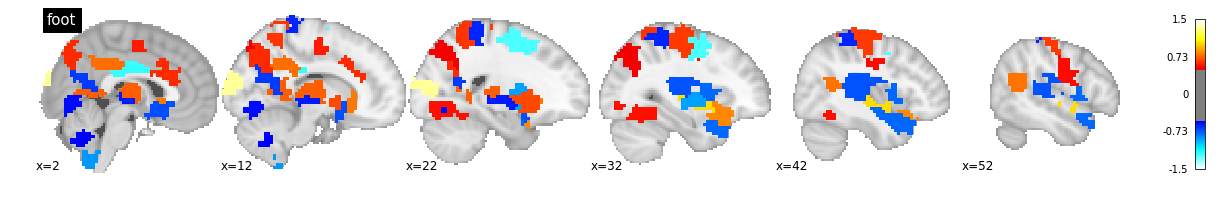

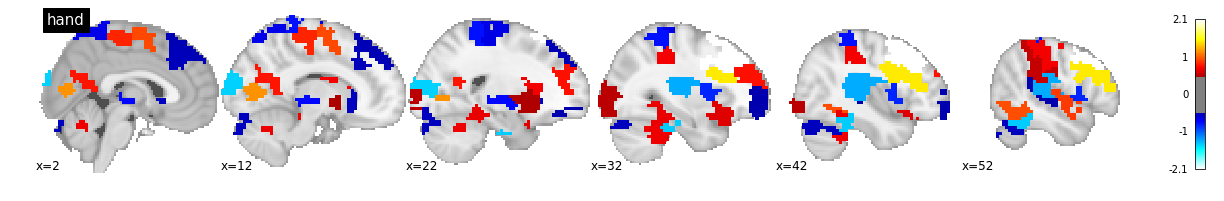

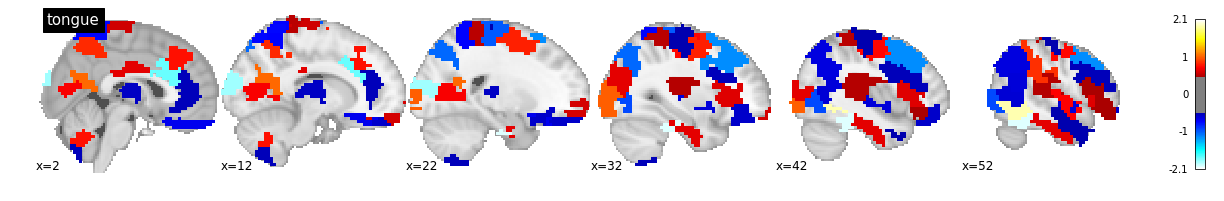

In [4]:
###SVM classifier
##feature matrix
fmri_data = np.vstack(subjects_tc_matrix)
label_data = np.vstack(subjects_trial_label_matrix).reshape(Subject_Num*Trial_Num,)
print(fmri_data.shape,label_data.shape)

condition_mask = pd.Series(label_data).isin(np.unique(list(task_contrasts.values())))
X_data = fmri_data[condition_mask,]
Y_data = label_data[condition_mask]

##build a simple classifier using SVM
from sklearn import svm,metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_data_scaled = X_data #preprocessing.scale(X_data) #with zero mean and unit variance.
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf.predict(X_data_scaled),Y_data)
print("Accuracy of prediction with SVM-RBF kernel: %4f" % acc_score)

my_cv_fold = 10
clf = svm.SVC(decision_function_shape='ovo')
scores = cross_val_score(clf, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
print(scores)

####to show the coefficients
clf_lin = svm.SVC(decision_function_shape='ovr',kernel='linear')
clf_lin.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf_lin.predict(X_data_scaled),Y_data)
print("Accuracy of prediction with SVM-linear kernel: %4f" % acc_score)
scores_lin = cross_val_score(clf_lin, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
print(scores_lin)
#print(clf_lin.support_vectors_.shape)
#print(clf_lin.n_support_ )

mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
mist_atlas.fit_transform(fmri_file,confounds=confound_file)
roi_coefs = clf_lin.coef_
svc_coef_img = mist_atlas.inverse_transform(roi_coefs)
print(svc_coef_img.shape)
##svc_coef_img.to_filename('fmri_decoding_motor_svc_weights.nii.gz')

import matplotlib.pyplot as plt
%matplotlib inline
from nilearn import plotting,image
target_name=np.unique(list(task_contrasts.values()))
ii = 0;
for img in image.iter_img(svc_coef_img):
    plotting.plot_stat_map(img,display_mode="x",cut_coords=range(2, 53, 10),threshold=0.5,title=target_name[ii])
    ii += 1

In [ ]:
##split data into training and testing based on session
##pick one random session/run as testing and validation
from random import randint
test_sid = randint(0, Subject_Num-1)
val_sid = randint(0, Subject_Num-1)
print(test_sid,val_sid)

fmri_data_cnn_test = np.array(fmri_data_cnn[test_sid])
fmri_data_cnn_test = np.transpose(fmri_data_cnn_test.reshape((img_rows,img_cols,np.prod(fmri_data_trial.shape[2:]))),(2,0,1))

fmri_data_cnn_val = np.array(fmri_data_cnn[val_sid])
fmri_data_cnn_val = np.transpose(fmri_data_cnn_val.reshape((img_rows,img_cols,np.prod(fmri_data_trial.shape[2:]))),(2,0,1))

fmri_data_cnn_train = np.array([x for i, x in enumerate(fmri_data_cnn) if i != test_sid and i != val_sid]) 
print(fmri_data_cnn_train.shape)
fmri_data_cnn_train = np.vstack(np.transpose(fmri_data_cnn_train.reshape((Subject_Num-2,img_rows,img_cols,np.prod(fmri_img_trial.shape[2:]))),(0,3,1,2)))

label_data_cnn_test = np.repeat(label_data_cnn[test_sid],img_deps,axis=0)
label_data_cnn_val = np.repeat(label_data_cnn[val_sid],img_deps,axis=0)
label_data_cnn_train = np.array([x for i, x in enumerate(label_data_cnn) if i != test_sid and i != val_sid]) 
label_data_cnn_train = np.vstack(np.repeat(label_data_cnn_train,img_deps,axis=1)).flatten()
'''
fmri_data_cnn = np.vstack(np.transpose(np.array(fmri_data_cnn),(0,3,1,2)))
label_data_cnn = np.vstack(label_data_cnn).reshape(Subject_Num*fmri_data_trial.shape[-1],)
print(fmri_data_cnn.shape,label_data_cnn.shape)
'''

##preprocess features and labels
from sklearn import preprocessing
X_train = np.expand_dims(np.float32(fmri_data_cnn_train)/np.max(fmri_data_cnn_train),3) #
X_test = np.expand_dims(np.float32(fmri_data_cnn_test)/np.max(fmri_data_cnn_train),3) #
X_val = np.expand_dims(np.float32(fmri_data_cnn_val)/np.max(fmri_data_cnn_train),3) #
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_train_int = le.transform(label_data_cnn_train)
Y_train = np_utils.to_categorical(Y_train_int)
Y_test_int = le.transform(label_data_cnn_test)
Y_test = np_utils.to_categorical(Y_test_int)
Y_val_int = le.transform(label_data_cnn_val)
Y_val = np_utils.to_categorical(Y_val_int)
nb_class = len(np.unique(list(task_contrasts.values())))

'''
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train_label,test_size=1./19, random_state=10, shuffle=False)
'''

print(X_train.shape,Y_train.shape,X_test.shape)
print('Samples for training: %d and testing %d and validating %d with %d classes' % (X_train.shape[0],X_test.shape[0],X_val.shape[0],nb_class))


In [5]:
###prepare the data samples
import numpy as np
from keras.utils import np_utils

##feature matrix
fmri_data = np.vstack(subjects_tc_matrix)
label_data = np.vstack(subjects_trial_label_matrix).reshape(Subject_Num*Trial_Num,)
target_name=np.unique(label_data)   ##np.unique(list(task_contrasts.values())) ##whether to exclude 'rest'
condition_mask = pd.Series(label_data).isin(target_name)
X_data = fmri_data[condition_mask,]
Y_data = label_data[condition_mask]

from sklearn import preprocessing
X_data_scaled = preprocessing.scale(X_data) #with zero mean and unit variance.
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_data_int = le.transform(Y_data)
Y_data_label = np_utils.to_categorical(Y_data_int)

print(X_data_scaled.shape,Y_data_label.shape)

Using TensorFlow backend.


(2080, 210) (2080, 4)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(model_history):
    plt.figure()
    plt.subplot(121)
    plt.plot(model_history.history['acc'],color='r')
    plt.plot(model_history.history['val_acc'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training','Validation'])
    
    plt.subplot(122)
    plt.plot(model_history.history['loss'],color='r')
    plt.plot(model_history.history['val_loss'],color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')
    plt.legend(['Training','Validation'])

In [ ]:
######fully-connected neural networks
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

Nfeatures = X_data_scaled.shape[1]   
layers = 3
hidden_size = 32
input0 = Input(shape=(Nfeatures,))
drop1 = input0 
for li in np.arange(layers):
    hidden1 = Dense(hidden_size,activation='relu')(drop1)
    drop1 = Dropout(0.25)(hidden1)
    hidden_size *= 2

hidden2 = Dense(128,activation='relu')(drop1)
drop2 = Dropout(0.5)(hidden2)
out = Dense(len(target_name), activation='softmax')(drop2)

model = Model(inputs=input0,outputs=out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

####running the model
import time
start_time = time.clock()

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X_data_scaled, Y_data_label,test_size=0.1, random_state=10)
print('Samples for training: %d and testing %d with %d features' % (X_train.shape[0],X_test.shape[0],X_train.shape[1]))

model_history = model.fit(X_train,Y_train,batch_size=512,epochs=1000,validation_split=0.05)
plot_history(model_history)
print('Time Usage in seconds: {}'.format(time.clock()-start_time))

test_loss,test_acc = model.evaluate(X_test,Y_test)
print('Testing sets: Loss: %4f and Accuracy: %4f' % (test_loss,test_acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6752      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

1778/1778 [==============================] - 0s 14us/step - loss: 0.5586 - acc: 0.7902 - val_loss: 0.7972 - val_acc: 0.7447
Epoch 107/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.5530 - acc: 0.7958 - val_loss: 0.7910 - val_acc: 0.7553
Epoch 108/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.5237 - acc: 0.8127 - val_loss: 0.7880 - val_acc: 0.7660
Epoch 109/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.5338 - acc: 0.8127 - val_loss: 0.7863 - val_acc: 0.7553
Epoch 110/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.5308 - acc: 0.7947 - val_loss: 0.7807 - val_acc: 0.7553
Epoch 111/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.5422 - acc: 0.8009 - val_loss: 0.8021 - val_acc: 0.7447
Epoch 112/1000
1778/1778 [==============================] - 0s 20us/step - loss: 0.5242 - acc: 0.8065 - val_loss: 0.7886 - val_acc: 0.7553
Epoch 113/1000
1778/1778 [================

1778/1778 [==============================] - 0s 14us/step - loss: 0.3600 - acc: 0.8735 - val_loss: 0.7722 - val_acc: 0.8191
Epoch 166/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3611 - acc: 0.8706 - val_loss: 0.7578 - val_acc: 0.7872
Epoch 167/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3151 - acc: 0.8853 - val_loss: 0.7583 - val_acc: 0.7979
Epoch 168/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3463 - acc: 0.8785 - val_loss: 0.7668 - val_acc: 0.7979
Epoch 169/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3281 - acc: 0.8886 - val_loss: 0.7645 - val_acc: 0.8085
Epoch 170/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3325 - acc: 0.8870 - val_loss: 0.7508 - val_acc: 0.7979
Epoch 171/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.3349 - acc: 0.8858 - val_loss: 0.7351 - val_acc: 0.8085
Epoch 172/1000
1778/1778 [================

1778/1778 [==============================] - 0s 14us/step - loss: 0.2466 - acc: 0.9123 - val_loss: 0.7754 - val_acc: 0.8085
Epoch 225/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.2699 - acc: 0.9100 - val_loss: 0.7692 - val_acc: 0.8191
Epoch 226/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.2385 - acc: 0.9207 - val_loss: 0.7290 - val_acc: 0.8191
Epoch 227/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.2471 - acc: 0.9201 - val_loss: 0.7340 - val_acc: 0.8085
Epoch 228/1000
1778/1778 [==============================] - 0s 19us/step - loss: 0.2388 - acc: 0.9168 - val_loss: 0.7442 - val_acc: 0.8085
Epoch 229/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.2367 - acc: 0.9173 - val_loss: 0.7468 - val_acc: 0.7979
Epoch 230/1000
1778/1778 [==============================] - 0s 19us/step - loss: 0.2756 - acc: 0.9021 - val_loss: 0.7284 - val_acc: 0.8404
Epoch 231/1000
1778/1778 [================

1778/1778 [==============================] - 0s 19us/step - loss: 0.1820 - acc: 0.9438 - val_loss: 0.7943 - val_acc: 0.8191
Epoch 284/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1828 - acc: 0.9387 - val_loss: 0.7887 - val_acc: 0.8191
Epoch 285/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.2013 - acc: 0.9336 - val_loss: 0.7904 - val_acc: 0.7872
Epoch 286/1000
1778/1778 [==============================] - 0s 20us/step - loss: 0.2021 - acc: 0.9297 - val_loss: 0.8063 - val_acc: 0.7766
Epoch 287/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1876 - acc: 0.9409 - val_loss: 0.8027 - val_acc: 0.7979
Epoch 288/1000
1778/1778 [==============================] - 0s 19us/step - loss: 0.1857 - acc: 0.9370 - val_loss: 0.7867 - val_acc: 0.8191
Epoch 289/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1818 - acc: 0.9364 - val_loss: 0.7661 - val_acc: 0.8298
Epoch 290/1000
1778/1778 [================

1778/1778 [==============================] - 0s 20us/step - loss: 0.1664 - acc: 0.9438 - val_loss: 0.8364 - val_acc: 0.8298
Epoch 343/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1572 - acc: 0.9522 - val_loss: 0.8246 - val_acc: 0.8191
Epoch 344/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1695 - acc: 0.9381 - val_loss: 0.8320 - val_acc: 0.8298
Epoch 345/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1723 - acc: 0.9432 - val_loss: 0.8369 - val_acc: 0.8191
Epoch 346/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1460 - acc: 0.9533 - val_loss: 0.8262 - val_acc: 0.8404
Epoch 347/1000
1778/1778 [==============================] - 0s 20us/step - loss: 0.1556 - acc: 0.9454 - val_loss: 0.8580 - val_acc: 0.8191
Epoch 348/1000
1778/1778 [==============================] - 0s 19us/step - loss: 0.1461 - acc: 0.9494 - val_loss: 0.8775 - val_acc: 0.8191
Epoch 349/1000
1778/1778 [================

1778/1778 [==============================] - 0s 20us/step - loss: 0.1234 - acc: 0.9567 - val_loss: 0.8854 - val_acc: 0.8298
Epoch 402/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1562 - acc: 0.9494 - val_loss: 0.9004 - val_acc: 0.8191
Epoch 403/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1589 - acc: 0.9539 - val_loss: 0.9192 - val_acc: 0.8298
Epoch 404/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1406 - acc: 0.9511 - val_loss: 0.9425 - val_acc: 0.7979
Epoch 405/1000
1778/1778 [==============================] - 0s 19us/step - loss: 0.1216 - acc: 0.9618 - val_loss: 0.9492 - val_acc: 0.7872
Epoch 406/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1361 - acc: 0.9556 - val_loss: 0.9374 - val_acc: 0.7872
Epoch 407/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1381 - acc: 0.9550 - val_loss: 0.9230 - val_acc: 0.7979
Epoch 408/1000
1778/1778 [================

1778/1778 [==============================] - 0s 20us/step - loss: 0.1256 - acc: 0.9629 - val_loss: 0.9342 - val_acc: 0.8191
Epoch 461/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1168 - acc: 0.9651 - val_loss: 0.9399 - val_acc: 0.8191
Epoch 462/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1414 - acc: 0.9477 - val_loss: 0.9661 - val_acc: 0.8191
Epoch 463/1000
1778/1778 [==============================] - 0s 20us/step - loss: 0.1302 - acc: 0.9573 - val_loss: 0.9543 - val_acc: 0.7979
Epoch 464/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1154 - acc: 0.9601 - val_loss: 0.9477 - val_acc: 0.7660
Epoch 465/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1333 - acc: 0.9550 - val_loss: 0.9253 - val_acc: 0.7872
Epoch 466/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1145 - acc: 0.9595 - val_loss: 0.9132 - val_acc: 0.7979
Epoch 467/1000
1778/1778 [================

1778/1778 [==============================] - 0s 15us/step - loss: 0.0992 - acc: 0.9702 - val_loss: 1.0127 - val_acc: 0.8085
Epoch 520/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1050 - acc: 0.9679 - val_loss: 1.0160 - val_acc: 0.7979
Epoch 521/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1089 - acc: 0.9623 - val_loss: 1.0109 - val_acc: 0.7766
Epoch 522/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1222 - acc: 0.9606 - val_loss: 1.0246 - val_acc: 0.7872
Epoch 523/1000
1778/1778 [==============================] - 0s 20us/step - loss: 0.1233 - acc: 0.9567 - val_loss: 1.0084 - val_acc: 0.8085
Epoch 524/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1615 - acc: 0.9471 - val_loss: 0.9943 - val_acc: 0.7872
Epoch 525/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1274 - acc: 0.9505 - val_loss: 1.0055 - val_acc: 0.7872
Epoch 526/1000
1778/1778 [================

1778/1778 [==============================] - 0s 20us/step - loss: 0.1114 - acc: 0.9674 - val_loss: 1.0858 - val_acc: 0.7766
Epoch 579/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.0993 - acc: 0.9685 - val_loss: 1.1064 - val_acc: 0.7872
Epoch 580/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.0934 - acc: 0.9685 - val_loss: 1.0901 - val_acc: 0.7979
Epoch 581/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1051 - acc: 0.9674 - val_loss: 1.0747 - val_acc: 0.7872
Epoch 582/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1077 - acc: 0.9702 - val_loss: 1.0644 - val_acc: 0.7979
Epoch 583/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.0812 - acc: 0.9724 - val_loss: 1.0622 - val_acc: 0.7766
Epoch 584/1000
1778/1778 [==============================] - 0s 15us/step - loss: 0.1111 - acc: 0.9668 - val_loss: 1.0562 - val_acc: 0.7766
Epoch 585/1000
1778/1778 [================

1778/1778 [==============================] - 0s 19us/step - loss: 0.1181 - acc: 0.9629 - val_loss: 1.0538 - val_acc: 0.7660
Epoch 638/1000
1778/1778 [==============================] - 0s 81us/step - loss: 0.0939 - acc: 0.9651 - val_loss: 1.0518 - val_acc: 0.8085
Epoch 639/1000
1778/1778 [==============================] - 0s 23us/step - loss: 0.1108 - acc: 0.9657 - val_loss: 1.0739 - val_acc: 0.8085
Epoch 640/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1100 - acc: 0.9623 - val_loss: 1.0260 - val_acc: 0.7979
Epoch 641/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1067 - acc: 0.9657 - val_loss: 0.9962 - val_acc: 0.8191
Epoch 642/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.1044 - acc: 0.9657 - val_loss: 0.9823 - val_acc: 0.8191
Epoch 643/1000
1778/1778 [==============================] - 0s 14us/step - loss: 0.0967 - acc: 0.9702 - val_loss: 0.9986 - val_acc: 0.7979
Epoch 644/1000
1778/1778 [================

In [7]:
''' expose different GPUs  if you are running multiple TensorFlow programs on the same machine,
Otherwise, TensorFlow will attempt to allocate almost the entire memory on all of the available GPUs,
which prevents other processes from using those GPU
'''
##to activate gpu tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES="0,1"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5188679202988478175
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11801106842
locality {
  bus_id: 2
}
incarnation: 3966842135177949041
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:82:00.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11801106842
locality {
  bus_id: 2
}
incarnation: 149896611939767200
physical_device_desc: "device: 1, name: Tesla P100-PCIE-12GB, pci bus id: 0000:83:00.0, compute capability: 6.0"
]
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES="0,1"


In [5]:
###function for constructing a cnn model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

def build_cnn_model(input_shape,out_shape,filters=32,convsize=3,poolsize=2,hidden_size=128,conv_layers=2):
    
#     import keras.backend as K
#     if K.image_data_format() == 'channels_first':
#         img_shape = (1,img_rows,img_cols)
#     elif K.image_data_format() == 'channels_last':
#         img_shape = (img_rows,img_cols,1)
    
    
    input0 = Input(shape=input_shape)
    drop1 = input0
    for li in range(conv_layers):
        conv1 = Conv2D(filters, (convsize,convsize), padding='same', activation='relu')(drop1)
        conv1 = Conv2D(filters, (convsize,convsize), padding='same', activation='relu')(conv1)
        pool1 = MaxPooling2D((poolsize,poolsize))(conv1)
        drop1 = Dropout(0.25)(pool1)
        filters *= 2

    '''
    conv2 = Conv2D(filters*2,(convsize,convsize), padding='same',activation='relu')(drop1)
    conv2 = Conv2D(filters*2,(convsize,convsize),padding='same',activation='relu')(conv2)
    pool2 = MaxPooling2D((poolsize,poolsize))(conv2)
    drop2 = Dropout(0.25)(pool2)
    '''
    drop2 = drop1
    flat = Flatten()(drop2)
    hidden = Dense(hidden_size,activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    out = Dense(out_shape,activation='softmax')(drop3)
    
    model = Model(inputs=input0,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

Using TensorFlow backend.


In [6]:
Subject_Num = len(fmri_files)
fmri_files_Img = []
for subj in range(Subject_Num):
    pathsub = Path(os.path.dirname(fmri_files[subj]))
    #print(sub_name[subj],coding_direct[subj])
    fmri_files_Img.append(str(sorted(pathsub.glob("_".join(["tfMRI", modality])+"*.nii.gz"))[0]))

print('%d subjects included in the dataset' % len(fmri_files_Img))
if len(fmri_files_Img) != len(fmri_files):
    print('Mismatching number of fmri data files! Please check the data in %s/  !' % str(pathroot))
print(fmri_files_Img)


2167 subjects included in the dataset
['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii.gz', '/home/yuzhang/projects/rrg-pbellec/DATA/

In [ ]:
##prepare the data for cnn
#using each axial slice as one sample
fmri_data_cnn = [];
label_data_cnn = [];
print(Subject_Num)
for subj in np.arange(100):
    trial_mask = pd.Series(subjects_trial_label_matrix.loc[subj,:]).isin(np.unique(list(task_contrasts.values()))) ##['hand', 'foot','tongue']
    '''
    import nibabel as nib
    fmri_file = nib.load(fmri_files[subj])
    fmri_img = fmri_file.get_data()
    print(fmri_img.shape)
    '''
    from nilearn.image import index_img
    fmri_img_trial = index_img(fmri_files_Img[subj], np.where(trial_mask)[0])
    ###use each slice along z-axis as one sample
    fmri_data_trial = fmri_img_trial.get_data()
    label_data_trial = np.array(subjects_trial_label_matrix.loc[subj,trial_mask])
    
    fmri_data_cnn.append(fmri_data_trial)
    label_data_cnn.append(label_data_trial)

img_rows, img_cols, img_deps = fmri_img_trial.shape[:-1]
print(img_rows,img_cols, img_deps)


2167


(81252, 61, 73, 1) (81252, 3) (9028, 61, 73, 1)
Samples for training: 81252 and testing 9028 with 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 61, 73, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 73, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 36, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 36, 64)        18496     
__________________________________

77189/77189 [==============================] - 27s 344us/step - loss: 0.0684 - acc: 0.9717 - val_loss: 0.0689 - val_acc: 0.9710
Epoch 97/100
77189/77189 [==============================] - 27s 346us/step - loss: 0.0687 - acc: 0.9721 - val_loss: 0.0682 - val_acc: 0.9717
Epoch 98/100
77189/77189 [==============================] - 27s 348us/step - loss: 0.0684 - acc: 0.9715 - val_loss: 0.0699 - val_acc: 0.9712
Epoch 99/100
77189/77189 [==============================] - 27s 350us/step - loss: 0.0703 - acc: 0.9710 - val_loss: 0.0685 - val_acc: 0.9714
Epoch 100/100
9028/9028 [==============================] - 2s 189us/step


[0.06636831837350987, 0.9728622064687639]

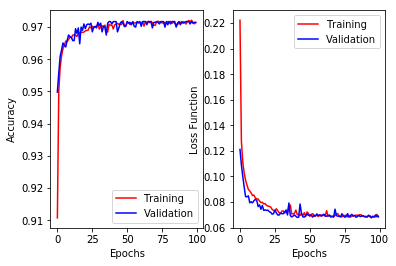

In [13]:
##split data into training and testing based on session
##pick one random session/run as testing and validation
from random import randint
test_sid = randint(0, Subject_Num-1)
val_sid = randint(0, Subject_Num-1)
print(test_sid,val_sid)

fmri_data_cnn_test = np.array(fmri_data_cnn[test_sid])
fmri_data_cnn_test = np.transpose(fmri_data_cnn_test.reshape((img_rows,img_cols,np.prod(fmri_data_trial.shape[2:]))),(2,0,1))

fmri_data_cnn_val = np.array(fmri_data_cnn[val_sid])
fmri_data_cnn_val = np.transpose(fmri_data_cnn_val.reshape((img_rows,img_cols,np.prod(fmri_data_trial.shape[2:]))),(2,0,1))

fmri_data_cnn_train = np.array([x for i, x in enumerate(fmri_data_cnn) if i != test_sid and i != val_sid]) 
print(fmri_data_cnn_train.shape)
fmri_data_cnn_train = np.vstack(np.transpose(fmri_data_cnn_train.reshape((Subject_Num-2,img_rows,img_cols,np.prod(fmri_img_trial.shape[2:]))),(0,3,1,2)))

label_data_cnn_test = np.repeat(label_data_cnn[test_sid],img_deps,axis=0)
label_data_cnn_val = np.repeat(label_data_cnn[val_sid],img_deps,axis=0)
label_data_cnn_train = np.array([x for i, x in enumerate(label_data_cnn) if i != test_sid and i != val_sid]) 
label_data_cnn_train = np.vstack(np.repeat(label_data_cnn_train,img_deps,axis=1)).flatten()
'''
fmri_data_cnn = np.vstack(np.transpose(np.array(fmri_data_cnn),(0,3,1,2)))
label_data_cnn = np.vstack(label_data_cnn).reshape(Subject_Num*fmri_data_trial.shape[-1],)
print(fmri_data_cnn.shape,label_data_cnn.shape)
'''

##preprocess features and labels
from sklearn import preprocessing
X_train = np.expand_dims(np.float32(fmri_data_cnn_train)/np.max(fmri_data_cnn_train),3) #
X_test = np.expand_dims(np.float32(fmri_data_cnn_test)/np.max(fmri_data_cnn_train),3) #
X_val = np.expand_dims(np.float32(fmri_data_cnn_val)/np.max(fmri_data_cnn_train),3) #
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_train_int = le.transform(label_data_cnn_train)
Y_train = np_utils.to_categorical(Y_train_int)
Y_test_int = le.transform(label_data_cnn_test)
Y_test = np_utils.to_categorical(Y_test_int)
Y_val_int = le.transform(label_data_cnn_val)
Y_val = np_utils.to_categorical(Y_val_int)
nb_class = len(np.unique(list(task_contrasts.values())))

'''
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train_label,test_size=1./19, random_state=10, shuffle=False)
'''

print(X_train.shape,Y_train.shape,X_test.shape)
print('Samples for training: %d and testing %d and validating %d with %d classes' % (X_train.shape[0],X_test.shape[0],X_val.shape[0],nb_class))


####model training and testing
import keras.backend as K

if K.image_data_format() == 'channels_first':
    img_shape = (1,img_rows,img_cols)
elif K.image_data_format() == 'channels_last':
    img_shape = (img_rows,img_cols,1)

model_test = build_cnn_model(img_shape,nb_class)


model_test_history = model_test.fit(X_train,Y_train,batch_size=256,epochs=100, validation_data=(X_val,Y_val))
plot_history(model_test_history)
model_test.evaluate(X_test,Y_test,verbose=1)

In [8]:
###function for constructing a 3d cnn model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from keras.models import Model

def build_cnn3d_model(input_shape,out_shape,filters=32,convsize=3,poolsize=2,hidden_size=128, conv_layers=2):
    
#     import keras.backend as K
#     if K.image_data_format() == 'channels_first':
#         img_shape = (1,img_rows,img_cols)
#     elif K.image_data_format() == 'channels_last':
#         img_shape = (img_rows,img_cols,1)
    
    
    input0 = Input(shape=input_shape)
    drop1 = input0
    for li in range(conv_layers):
        conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(drop1)
        conv1 = Conv3D(filters, (convsize,convsize,convsize), padding='same', activation='relu')(conv1)
        pool1 = MaxPooling3D((poolsize,poolsize,poolsize))(conv1)
        drop1 = Dropout(0.25)(pool1)
        filters *= 2
    '''
    conv2 = Conv3D(filters*4,(convsize,convsize,convsize), padding='same',activation='relu')(drop1)
    conv2 = Conv3D(filters*4,(convsize,convsize,convsize),padding='same',activation='relu')(conv2)
    pool2 = MaxPooling3D((poolsize,poolsize,poolsize))(conv2)
    drop2 = Dropout(0.25)(pool2)
    '''
    drop2 = drop1
    flat = Flatten()(drop2)
    hidden = Dense(hidden_size,activation='relu')(flat)
    drop3 = Dropout(0.5)(hidden)
    out = Dense(out_shape,activation='softmax')(drop3)
    
    model = Model(inputs=input0,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

In [9]:
##prepare the data for cnn
#using each axial slice as one sample
fmri_data_cnn = [];
label_data_cnn = [];
print(Subject_Num)
for subj in np.arange(Subject_Num):
    trial_mask = pd.Series(subjects_trial_label_matrix[subj]).isin(np.unique(list(task_contrasts.values()))) ##['hand', 'foot','tongue']
    '''
    import nibabel as nib
    fmri_file = nib.load(fmri_files[subj])
    fmri_img = fmri_file.get_data()
    print(fmri_img.shape)
    '''
    from nilearn.image import index_img
    fmri_img_trial = index_img(fmri_files[subj], np.where(trial_mask)[0])
    ###use each slice along z-axis as one sample
    fmri_data_trial = fmri_img_trial.get_data()
    label_data_trial = np.array(subjects_trial_label_matrix[subj])[trial_mask]
    
    fmri_data_cnn.append(fmri_data_trial)
    label_data_cnn.append(label_data_trial)

img_rows, img_cols, img_deps = fmri_img_trial.shape[:-1]
print(img_rows,img_cols, img_deps)

20
(1480, 61, 73, 61) (1480,)
61 73 61


In [ ]:
##split data into training and testing based on session
##pick one random session/run as testing and validation
from random import randint
test_sid = randint(0, Subject_Num-1)
val_sid = randint(0, Subject_Num-1)
print(test_sid,val_sid)

fmri_data_cnn3d_test = np.transpose(np.array(fmri_data_cnn[test_sid]),(3,0,1,2))
fmri_data_cnn3d_val = np.transpose(np.array(fmri_data_cnn[val_sid]),(3,0,1,2))

fmri_data_cnn3d_train = np.array([x for i, x in enumerate(fmri_data_cnn) if i != test_sid and i != val_sid]) 
print(fmri_data_cnn3d_train.shape)
fmri_data_cnn3d_train = np.vstack(np.transpose(fmri_data_cnn3d_train,(0,4,1,2,3)))

label_data_cnn3d_test = label_data_cnn[test_sid]
label_data_cnn3d_val = label_data_cnn[val_sid]
label_data_cnn3d_train = np.array([x for i, x in enumerate(label_data_cnn) if i != test_sid and i != val_sid]) 
label_data_cnn3d_train = np.vstack(label_data_cnn3d_train).flatten()
'''
fmri_data_cnn = np.vstack(np.transpose(np.array(fmri_data_cnn),(0,3,1,2)))
label_data_cnn = np.vstack(label_data_cnn).reshape(Subject_Num*fmri_data_trial.shape[-1],)
print(fmri_data_cnn.shape,label_data_cnn.shape)
'''

##preprocess features and labels
from sklearn import preprocessing
X_train = np.expand_dims(np.float32(fmri_data_cnn3d_train)/np.max(fmri_data_cnn3d_train),4) #
X_test = np.expand_dims(np.float32(fmri_data_cnn3d_test)/np.max(fmri_data_cnn3d_train),4) #
X_val = np.expand_dims(np.float32(fmri_data_cnn3d_val)/np.max(fmri_data_cnn3d_train),4) #
le = preprocessing.LabelEncoder()
le.fit(target_name)
Y_train_int = le.transform(label_data_cnn3d_train)
Y_train = np_utils.to_categorical(Y_train_int)
Y_test_int = le.transform(label_data_cnn3d_test)
Y_test = np_utils.to_categorical(Y_test_int)
Y_val_int = le.transform(label_data_cnn3d_val)
Y_val = np_utils.to_categorical(Y_val_int)
nb_class = len(np.unique(list(task_contrasts.values())))

'''
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train_label,test_size=1./19, random_state=10, shuffle=False)
'''

print(X_train.shape,Y_train.shape,X_test.shape)
print('Samples for training: %d and testing %d and validating %d with %d classes' % (X_train.shape[0],X_test.shape[0],X_val.shape[0],nb_class))


###training and testing 3d-cnn model
import keras.backend as K

if K.image_data_format() == 'channels_first':
    img_shape_3d = (1,img_rows,img_cols,img_deps)
elif K.image_data_format() == 'channels_last':
    img_shape_3d = (img_rows,img_cols,img_deps, 1)

model_test_3d = build_cnn3d_model(img_shape_3d,nb_class)


model_test_3d_history = model_test_3d.fit(X_train,Y_train,batch_size=16,epochs=100, validation_data=(X_val,Y_val))
plot_history(model_test_3d_history)
model_test.evaluate(X_test,Y_test,verbose=1)

(1332, 61, 73, 61, 1) (1332, 3) (148, 61, 73, 61, 1)
Samples for training: 1332 and testing 148 with 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 61, 73, 61, 1)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 61, 73, 61, 16)    448       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 61, 73, 61, 16)    6928      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 30, 36, 30, 16)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 36, 30, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 30, 36, 30, 32)    13856     
_______________________________

In [1]:
###save the trained model
# serialize model to JSON
print("Saved 2d-cnn model to disk")
model_test_json = model_test.to_json()
with open("model_test_2dcnn.json", "w") as json_file:
    json_file.write(model_test_json)
# serialize weights to HDF5
model_test.save_weights("model_test_2dcnn.h5")

print("Saved 3d-cnn model to disk")
model_test_3d_json = model_test_3d.to_json()
with open("model_test_3dcnn.json", "w") as json_file:
    json_file.write(model_test_3d_json)
# serialize weights to HDF5
model_test_3d.save_weights("model_test_3dcnn.h5")

Saved 2d-cnn model to disk


NameError: name 'model_test' is not defined